## Machine Learning

###  Importing needed libraries and defining value formatters

In [230]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
import warnings

from math import sqrt
from matplotlib.ticker import FuncFormatter
from statsmodels.tsa.arima.model import ARIMA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, StandardScaler, PolynomialFeatures, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix

warnings.filterwarnings('ignore')

In [231]:
#pip install numpy
#pip install pandas
#pip install seaborn
#pip install statsmodels
#pip install matplotlib
#pip install itertools
#pip install warnings
#pip install math
#pip install sklearn

In [232]:
def millions_formatter(x, pos):
    return f'{x / 1e6} M'

def thousands_formatter(x, pos):
    return f'{x / 1e3} K'

def bilions_formatter(x, pos):
    return f'{x / 1e9} B'

def standard_decimal_notation_formatter(x):
    return '{:.2f}'.format(x)

### Lodind the datasets

In [233]:
population_df = pd.read_csv('population_df_1996.csv')
migration_df = pd.read_csv('migration_df_1996.csv')

In [234]:
#importing the merged file from the CA1_2_final which will be used for optimizing the Machine Learning algorithms
population_migration_df = pd.read_csv('population_migration_df.csv')

### Data aggregation of migration and the population datasets for the models

In [235]:
migration_net_corrected = migration_df[
    (migration_df['Origin or Destination'] == 'Net migration') & 
    (migration_df['Sex'] != 'Both sexes')
]
migration_aggregated_corrected = migration_net_corrected.groupby('Year')['VALUE'].sum().reset_index()


population_total_corrected = population_df[
    (population_df['Single Year of Age'] == 'All ages') & 
    (population_df['Sex'] != 'Both sexes')
]
population_aggregated_corrected = population_total_corrected.groupby('Year')['VALUE'].sum().reset_index()



### Data aggregation for Linear Regression

In [236]:
filtered_BothSex = population_df[(population_df['Single Year of Age'] == 'All ages') & (population_df['Sex'] == 'Both sexes') & (population_df['Year'] >= 2003)]
filtered_BothSex= filtered_BothSex.drop(['Single Year of Age', 'Sex', 'UNIT', 'Age category', 'Sex category'], axis =1)

filtered_BothSex

,Year,VALUE
2121,2003,3979853
2424,2004,4045188
2727,2005,4133839
3030,2006,4232929
3333,2007,4375842
3636,2008,4485070
3939,2009,4533395
4242,2010,4554763
4545,2011,4574888
4848,2012,4593697


In [237]:
population_aggregated_corrected.head(7)

,Year,VALUE
0,1996,3626087
1,1997,3664313
2,1998,3703082
3,1999,3741647
4,2000,3789536
5,2001,3847198
6,2002,3917203


In [238]:
migration_aggregated_corrected.head(7)

,Year,VALUE
0,1996,10.3
1,1997,32.1
2,1998,29.5
3,1999,30.4
4,2000,48.2
5,2001,54.8
6,2002,82.7


Merging the datasets on the 'Year' column and then convert the net migration figures to absolute numbers to match the scale of the population figures. 

In [239]:
merged_df_corrected = pd.merge(population_aggregated_corrected, migration_aggregated_corrected, on='Year', how='inner', suffixes=('_pop', '_mig'))
merged_df_corrected.rename(columns={'VALUE_pop': 'Population', 'VALUE_mig': 'Net Migration'}, inplace=True)
merged_df_corrected['Net Migration'] = merged_df_corrected['Net Migration'] * 1000

merged_df_corrected.head(7)

,Year,Population,Net Migration
0,1996,3626087,10300.0
1,1997,3664313,32100.0
2,1998,3703082,29500.0
3,1999,3741647,30400.0
4,2000,3789536,48200.0
5,2001,3847198,54800.0
6,2002,3917203,82700.0


### Visualizing some valuable Insights.

A time series plot to show the trend of the population over the years.


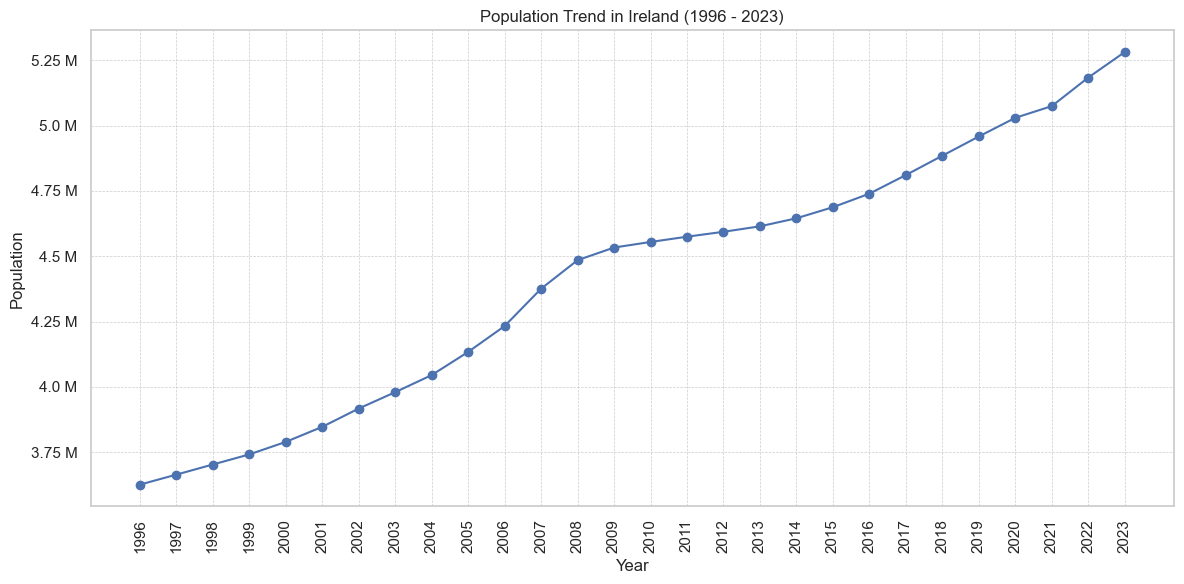

A time series plot to show the trend of the population over the years after 2022


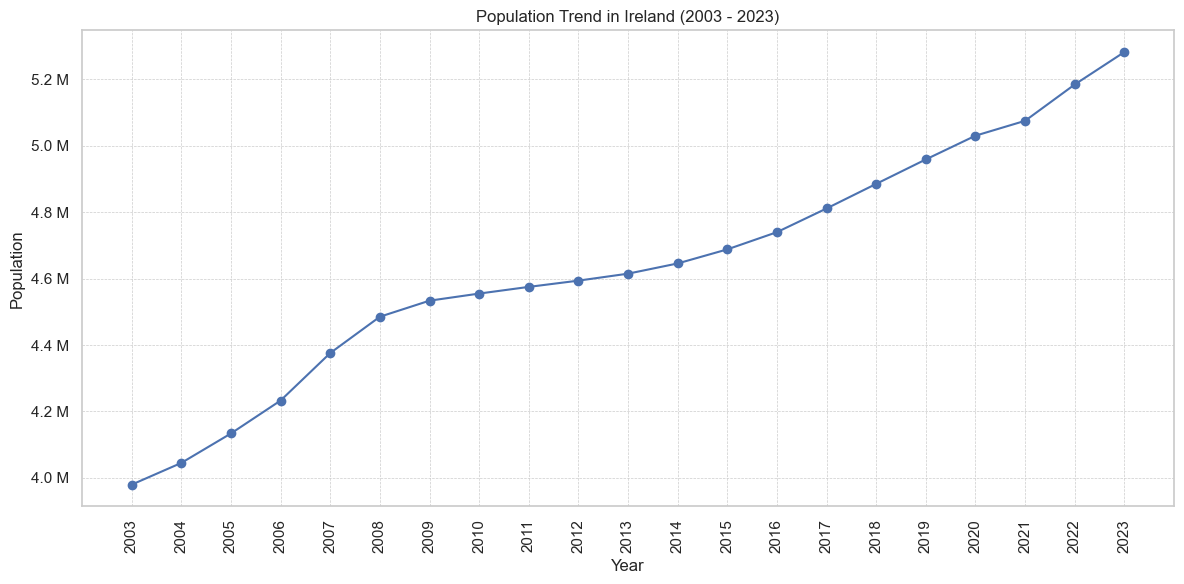

A time series plot to show the trend of net migration over the years.


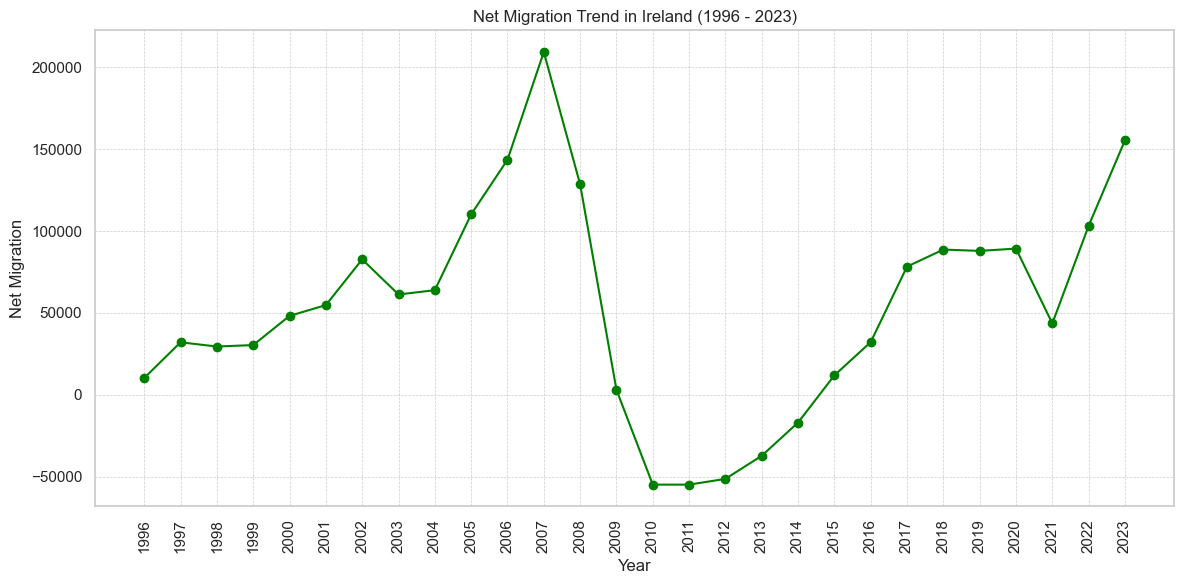

A scatter plot to visualize the relationship between net migration and population.


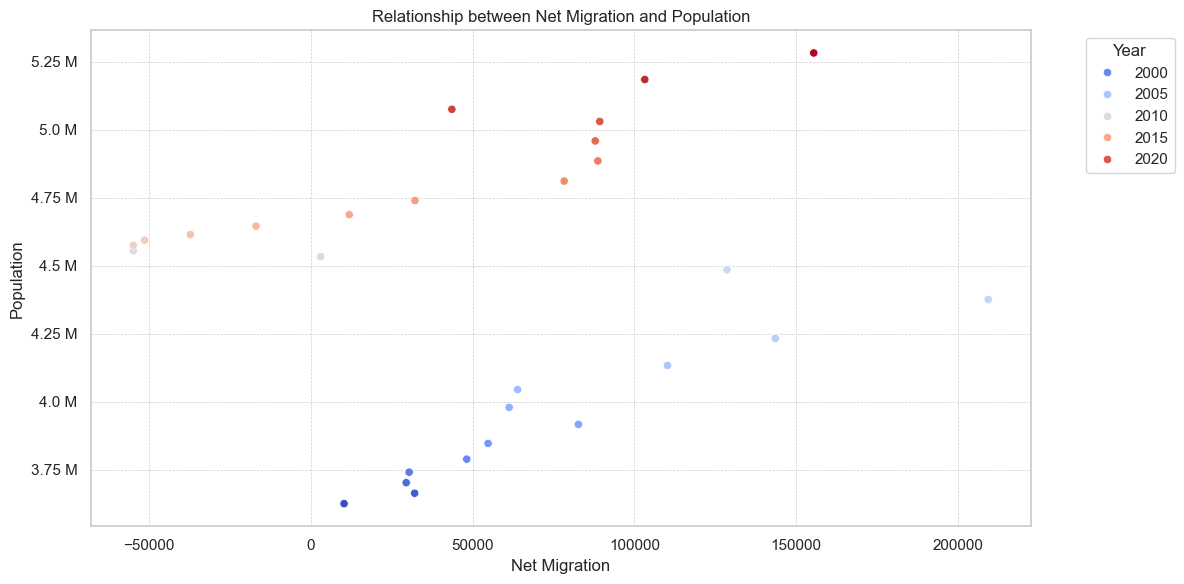

In [240]:
sns.set_style("whitegrid")

print('A time series plot to show the trend of the population over the years.')
plt.figure(figsize=(12, 6))
plt.plot(merged_df_corrected['Year'], merged_df_corrected['Population'], marker='o', linestyle='-')
plt.title('Population Trend in Ireland (1996 - 2023)')
plt.xlabel('Year')
plt.ylabel('Population')
years = merged_df_corrected['Year'].values
plt.xticks(years, rotation=90)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.tight_layout()
plt.show()

print('A time series plot to show the trend of the population over the years after 2022')
plt.figure(figsize=(12, 6))
plt.plot(filtered_BothSex['Year'], filtered_BothSex['VALUE'], marker='o', linestyle='-')
plt.title('Population Trend in Ireland (2003 - 2023)')
plt.xlabel('Year')
plt.ylabel('Population')
years = filtered_BothSex['Year'].values
plt.xticks(years, rotation=90)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.tight_layout()
plt.show()

print('A time series plot to show the trend of net migration over the years.')
plt.figure(figsize=(12, 6))
plt.plot(merged_df_corrected['Year'], merged_df_corrected['Net Migration'], marker='o', linestyle='-', color='green')
plt.title('Net Migration Trend in Ireland (1996 - 2023)')
plt.xlabel('Year')
plt.ylabel('Net Migration')
years = merged_df_corrected['Year'].values
plt.xticks(years, rotation=90)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print('A scatter plot to visualize the relationship between net migration and population.')
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Net Migration', y='Population', data=merged_df_corrected, hue='Year', palette="coolwarm")
plt.title('Relationship between Net Migration and Population')
plt.xlabel('Net Migration')
plt.ylabel('Population')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


#### **Insights:**
* **Population Trend:** This plot shows the trend of the population in Ireland from 1996 to 2023. As we can see there is a consistent increase over the years.

* **Net Migration Trend:** This plot illustrates the trend of net migration over the same period. There are fluctuations from year to year, with some years experiencing negative net migration (more emigrants than immigrants).

* **Relationship between Net Migration and Population:** The scatter plot indicates the relationship between net migration and population size for each year. The color gradient represents the progression of years. It seems that there is a general positive correlation, suggesting that higher net migration is often associated with a higher population in the subsequent years.

### Preparing the data for the Linear Regression

In [241]:
X = filtered_BothSex[['Year']]
y = filtered_BothSex['VALUE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

X_train, y_train

(      Year
 5151  2013
 6363  2017
 7575  2021
 3939  2009
 7878  2022
 3333  2007
 2727  2005
 3636  2008
 6969  2019
 4848  2012
 4242  2010
 7272  2020
 3030  2006
 2121  2003
 6666  2018
 5757  2015,
 5151    4614669
 6363    4810895
 7575    5074668
 3939    4533395
 7878    5183966
 3333    4375842
 2727    4133839
 3636    4485070
 6969    4958471
 4848    4593697
 4242    4554763
 7272    5029875
 3030    4232929
 2121    3979853
 6666    4884896
 5757    4687787
 Name: VALUE, dtype: int64)

In [242]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

#future_years = [2050, 2060, 2070]  # years we want to predict
future_years = [2050] 
future_data = pd.DataFrame({'Year': future_years})
predicted_population = model.predict(future_data)
print(f'Predicted population to {future_years[0]} is {predicted_population[0]:.0f}')

R-squared: 0.964272256633945
Predicted population to 2050 is 6678149


https://www.cso.ie/en/releasesandpublications/ep/p-plfp/populationandlabourforceprojections2017-2051/populationprojectionsresults/?fbclid=IwAR0y2ch0t6PVr-Rbk_qAo7pzcDPPPqGXHRWB4wnp5B9MK39WAtVmeEPauWo 

When compared to the Central Statistic Office we see that our estimated value of 6.7M is the same as the one we see on the Statistics Office. 

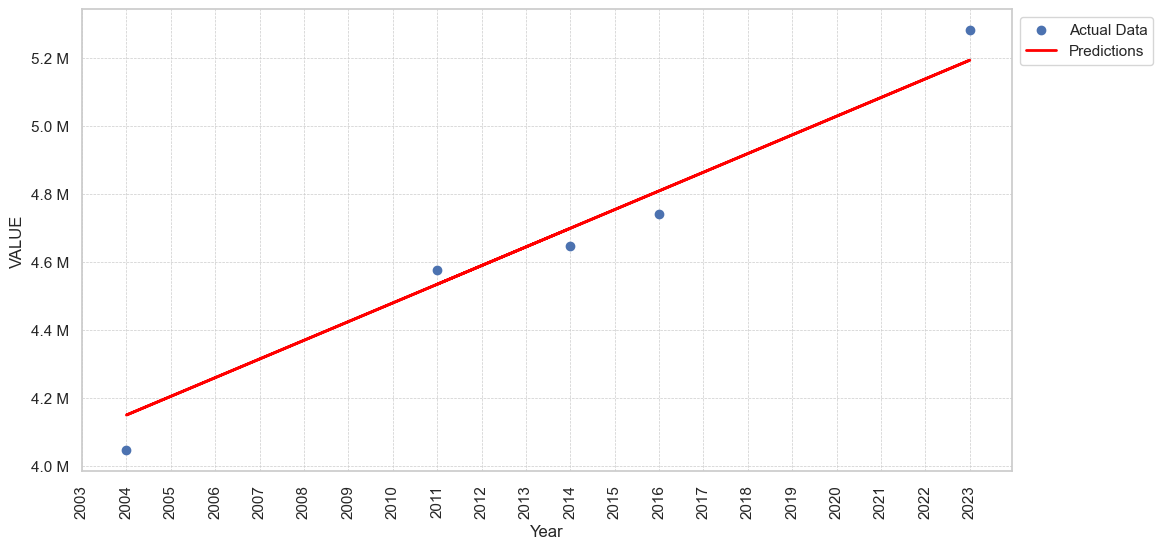

In [243]:
years_plot = X['Year'].unique()

plt.figure(figsize=(12, 6))
plt.scatter(X_test, y_test, label='Actual Data')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predictions')
plt.xlabel('Year')
plt.ylabel('VALUE')
plt.xticks(years_plot, rotation=90)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### Trying to convert to timeseries

In [244]:
filtered_BothSex['Year'] = pd.to_datetime(filtered_BothSex['Year'], format='%Y')
filtered_BothSex.set_index('Year', inplace=True)
filtered_BothSex

,VALUE
Year,
2003-01-01,3979853
2004-01-01,4045188
2005-01-01,4133839
2006-01-01,4232929
2007-01-01,4375842
2008-01-01,4485070
2009-01-01,4533395
2010-01-01,4554763
2011-01-01,4574888


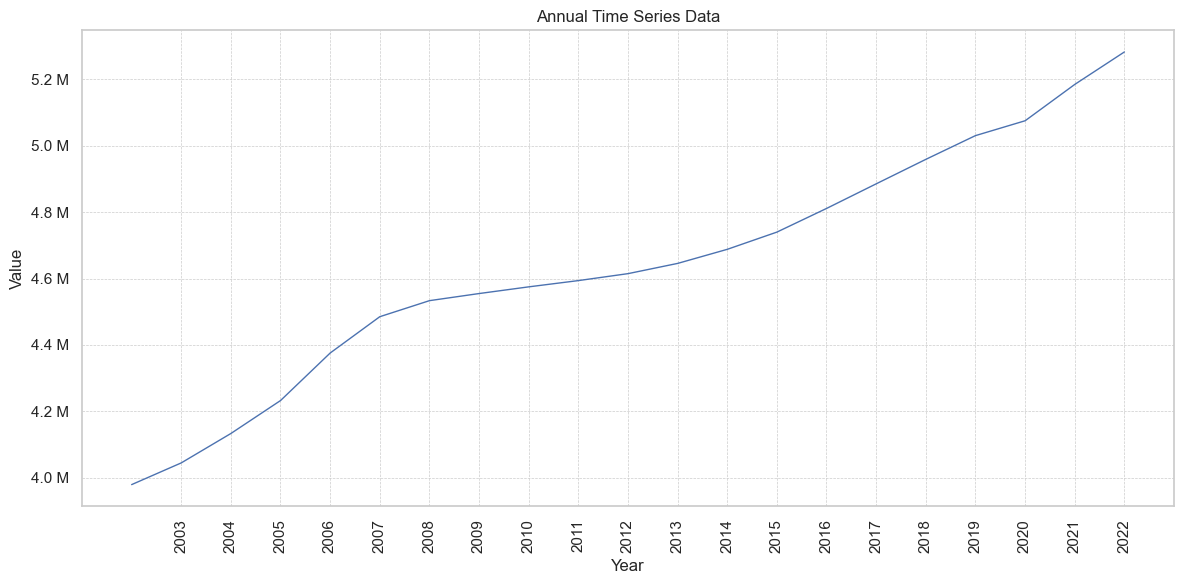

In [245]:
plt.figure(figsize=(12, 6))

xticks = pd.date_range(start=filtered_BothSex.index.min(), end=filtered_BothSex.index.max(), freq='A-DEC')
plt.xticks(xticks, [tick.strftime("%Y") for tick in xticks], rotation=90)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.plot(filtered_BothSex.index, filtered_BothSex['VALUE'], linewidth=1)
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Annual Time Series Data")
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.tight_layout()

plt.show()

In [246]:
filtered_BothSex.index.astype("int64").values
filtered_BothSex.values

array([[3979853],
       [4045188],
       [4133839],
       [4232929],
       [4375842],
       [4485070],
       [4533395],
       [4554763],
       [4574888],
       [4593697],
       [4614669],
       [4645440],
       [4687787],
       [4739597],
       [4810895],
       [4884896],
       [4958471],
       [5029875],
       [5074668],
       [5183966],
       [5281612]], dtype=int64)

In [247]:
filtered_BothSex.index.astype("int64").values.reshape(-1, 1)

array([[1041379200000000000],
       [1072915200000000000],
       [1104537600000000000],
       [1136073600000000000],
       [1167609600000000000],
       [1199145600000000000],
       [1230768000000000000],
       [1262304000000000000],
       [1293840000000000000],
       [1325376000000000000],
       [1356998400000000000],
       [1388534400000000000],
       [1420070400000000000],
       [1451606400000000000],
       [1483228800000000000],
       [1514764800000000000],
       [1546300800000000000],
       [1577836800000000000],
       [1609459200000000000],
       [1640995200000000000],
       [1672531200000000000]], dtype=int64)

In [248]:
X = filtered_BothSex.index.astype("int64").values.reshape(-1, 1)  # Features
y = filtered_BothSex['VALUE'].values 

X.shape, y.shape

((21, 1), (21,))

In [249]:
n_train = 13

def eval_on_features(features, target, regressor):
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]
    
    regressor.fit(X_train, y_train)
    y_pred_test = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    
    test_score = r2_score(y_test, y_pred_test)
    print(f"Test-set R^2: {test_score:.2f}")
    
    plt.figure(figsize=(10, 3))
    
    xticks = pd.date_range(start=filtered_BothSex.index.min(), end=filtered_BothSex.index.max(), freq='A-DEC')
    
    plt.plot(filtered_BothSex.index[:n_train], y_train, label="train")
    plt.plot(filtered_BothSex.index[n_train:], y_test, label="test")
    plt.plot(filtered_BothSex.index[:n_train], y_pred_train, '--', label="prediction train")
    plt.plot(filtered_BothSex.index[n_train:], y_pred_test, '--', label="prediction test")
    
    plt.xticks(xticks, xticks.strftime("%Y"), rotation=90)
    plt.legend()
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.title("Time Series Prediction")
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

Test-set R^2: 0.89


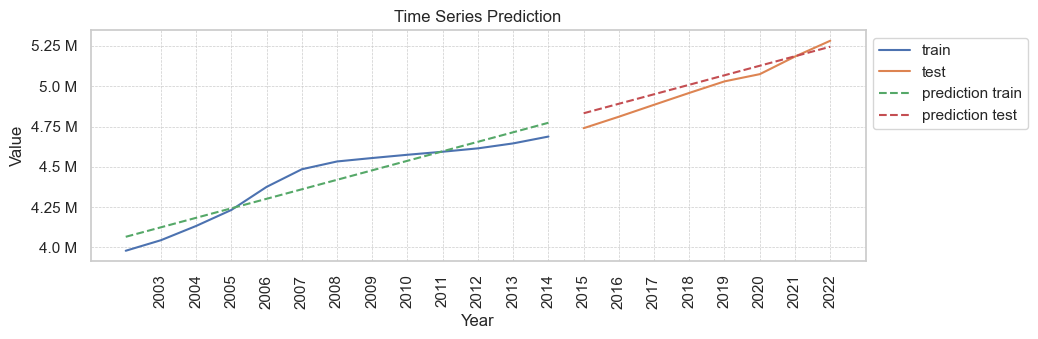

In [250]:
eval_on_features(X, y, LinearRegression())

Test-set R^2: -3.61


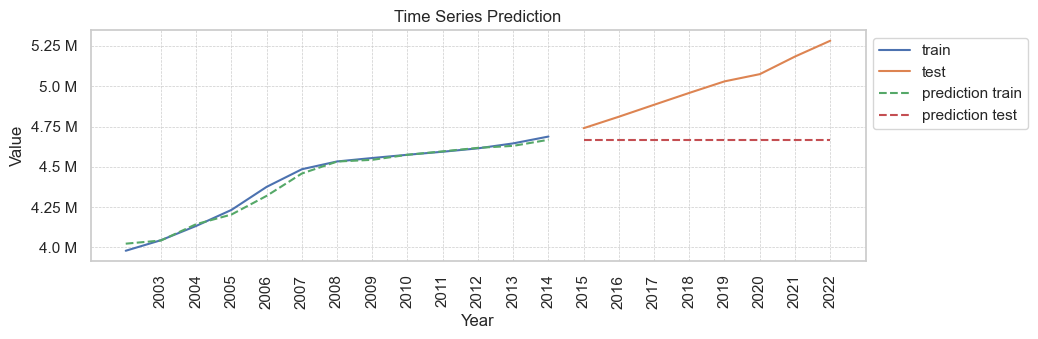

In [251]:
regressor = RandomForestRegressor(n_estimators = 10, random_state = 42)
eval_on_features(X, y, regressor)

In [252]:
# Declare an object (enc) by calling a method OneHotEncoder()
enc = OneHotEncoder()

# Create an array by calling a fit() method
X_year_onehot = enc.fit_transform(X).toarray()

X_year_onehot

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.,

Test-set R^2: -11.14


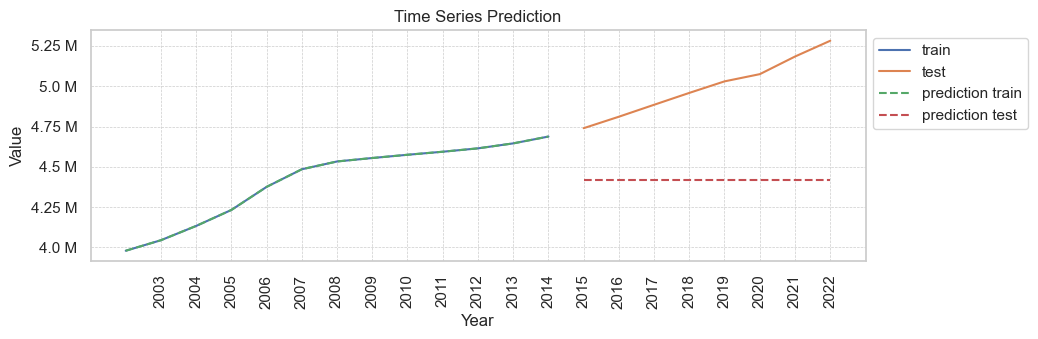

In [253]:
# Calling a method eval_on_features() to evaluate R^2 and plot
eval_on_features(X_year_onehot, y, LinearRegression())

Test-set R^2: 0.89


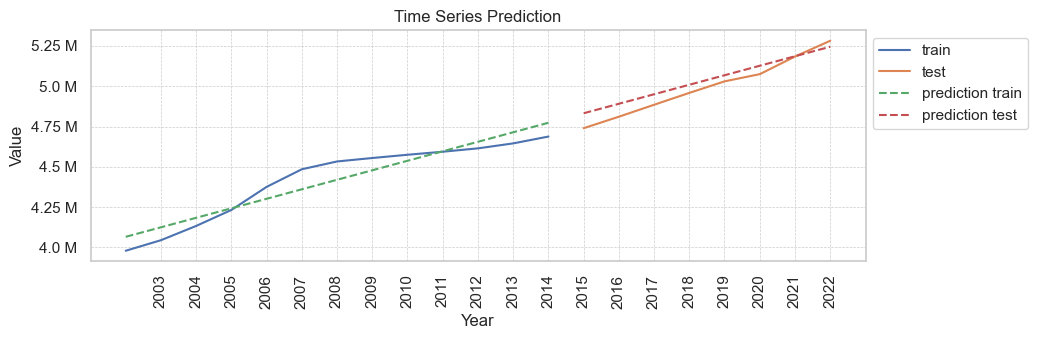

In [254]:
# Calling a method eval_on_features() to evaluate R^2 and plot 
eval_on_features(X, y, Ridge())

https://en.wikipedia.org/wiki/Polynomial_regression

$$ Linear Regression: y = ax + b $$

$$ Polynomial Regression: y = ax^2 + bx + x $$

Test-set R^2: -11.14


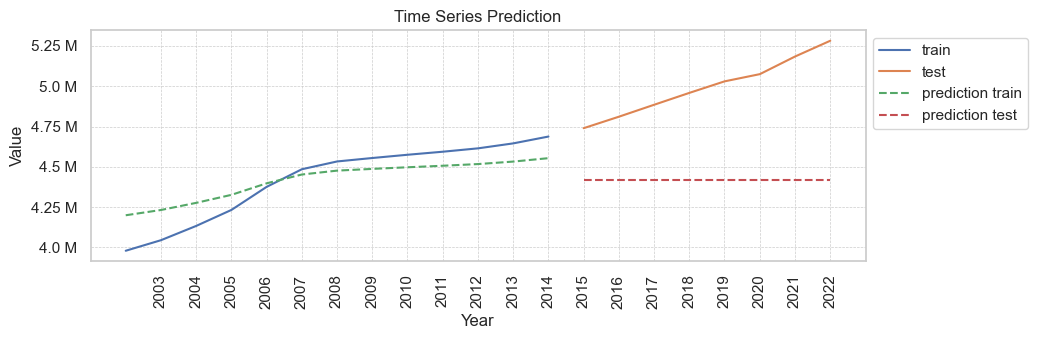

In [255]:

# Create and initialise an object named as PolynomialFeatures()
poly_transformer = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)

# Call fit() method to train the model
X_year_nehot_poly = poly_transformer.fit_transform(X_year_onehot)

# Initialise an object by calling a method Ridge()
lr = Ridge()

# Call a method eval_on_features() to evaluate R^2 and plot 
eval_on_features(X_year_nehot_poly, y, lr)

### Net Migration KNN and Decision Tree

Loading the not filtered dataset taking more data to extend the accuracity.

In [256]:
migration_df_for_ml = pd.read_csv('PEA18.20231016T141007.csv')

In [257]:
new_migration_for_analysis = migration_df_for_ml[(migration_df_for_ml['Country'] != 'All countries') & (migration_df_for_ml['Sex'] == 'Both sexes')]
new_migration_for_analysis = new_migration_for_analysis.drop(['STATISTIC', 'TLIST(A1)', 'Sex','C02719V03286', 'C02199V02655'], axis=1)

In [258]:
new_migration_for_analysis.head(7)

,STATISTIC Label,Year,Country,C02542V03077,Origin or Destination,UNIT,VALUE
0,Estimated Migration (Persons in April),1987,United Kingdom (1),1,Net migration,Thousand,-13.7
1,Estimated Migration (Persons in April),1987,United Kingdom (1),4,Emigrants: All destinations,Thousand,21.8
2,Estimated Migration (Persons in April),1987,United Kingdom (1),5,Immigrants: All origins,Thousand,8.1
9,Estimated Migration (Persons in April),1987,United States,1,Net migration,Thousand,-6.9
10,Estimated Migration (Persons in April),1987,United States,4,Emigrants: All destinations,Thousand,9.9
11,Estimated Migration (Persons in April),1987,United States,5,Immigrants: All origins,Thousand,3.0
18,Estimated Migration (Persons in April),1987,Canada,1,Net migration,Thousand,NaN


In [259]:
net_migration_data = new_migration_for_analysis[new_migration_for_analysis['Origin or Destination'] == 'Net migration']

net_migration_data['Target'] = (net_migration_data['VALUE'] > 0).astype(int)

le = LabelEncoder()
net_migration_data['Country_Encoded'] = le.fit_transform(net_migration_data['Country'])

X = net_migration_data[['Year', 'Country_Encoded']]
y = net_migration_data['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head(7)

,Year,Country_Encoded
2169,2017,6
1449,2007,6
1179,2003,0
792,1998,5
1863,2012,3
387,1992,0
1431,2006,3


In [260]:
y_train.head(7)

2169    1
1449    1
1179    0
792     1
1863    1
387     0
1431    1
Name: Target, dtype: int32

In [261]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_scaled, y_train)

y_pred_knn = knn_classifier.predict(X_test_scaled)

knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_accuracy


0.8269230769230769

#### Visualize the confusion matrix for KNN

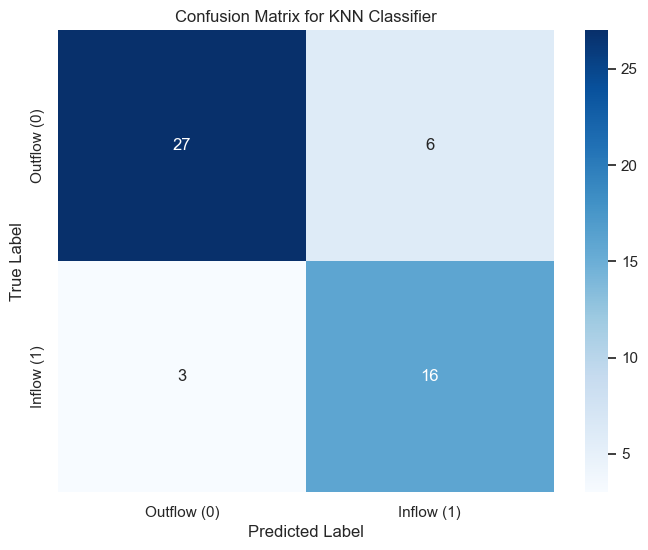

In [262]:
conf_mat_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_knn, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Outflow (0)', 'Inflow (1)'],
            yticklabels=['Outflow (0)', 'Inflow (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for KNN Classifier')
plt.show()

Here's the visualized confusion matrix for the k-Nearest Neighbors (KNN) classifier:

Top-left cell (True Negatives): For 47 instances in the test set, the actual migration trend was an outflow, and the model correctly predicted it as an outflow.
Top-right cell (False Positives): For 7 instances, the actual migration trend was an outflow, but the model incorrectly predicted it as an inflow.
Bottom-left cell (False Negatives): For 7 instances, the actual migration trend was an inflow, but the model incorrectly predicted it as an outflow.
Bottom-right cell (True Positives): For 21 instances in the test set, the actual migration trend was an inflow, and the model correctly predicted it as an inflow.

#### rain a Decision Tree classifier

In [263]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

y_pred_dt = dt_classifier.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
class_report_dt = classification_report(y_test, y_pred_dt)

accuracy_dt, class_report_dt

(0.8653846153846154,
 '              precision    recall  f1-score   support\n\n           0       0.88      0.91      0.90        33\n           1       0.83      0.79      0.81        19\n\n    accuracy                           0.87        52\n   macro avg       0.86      0.85      0.85        52\nweighted avg       0.86      0.87      0.86        52\n')

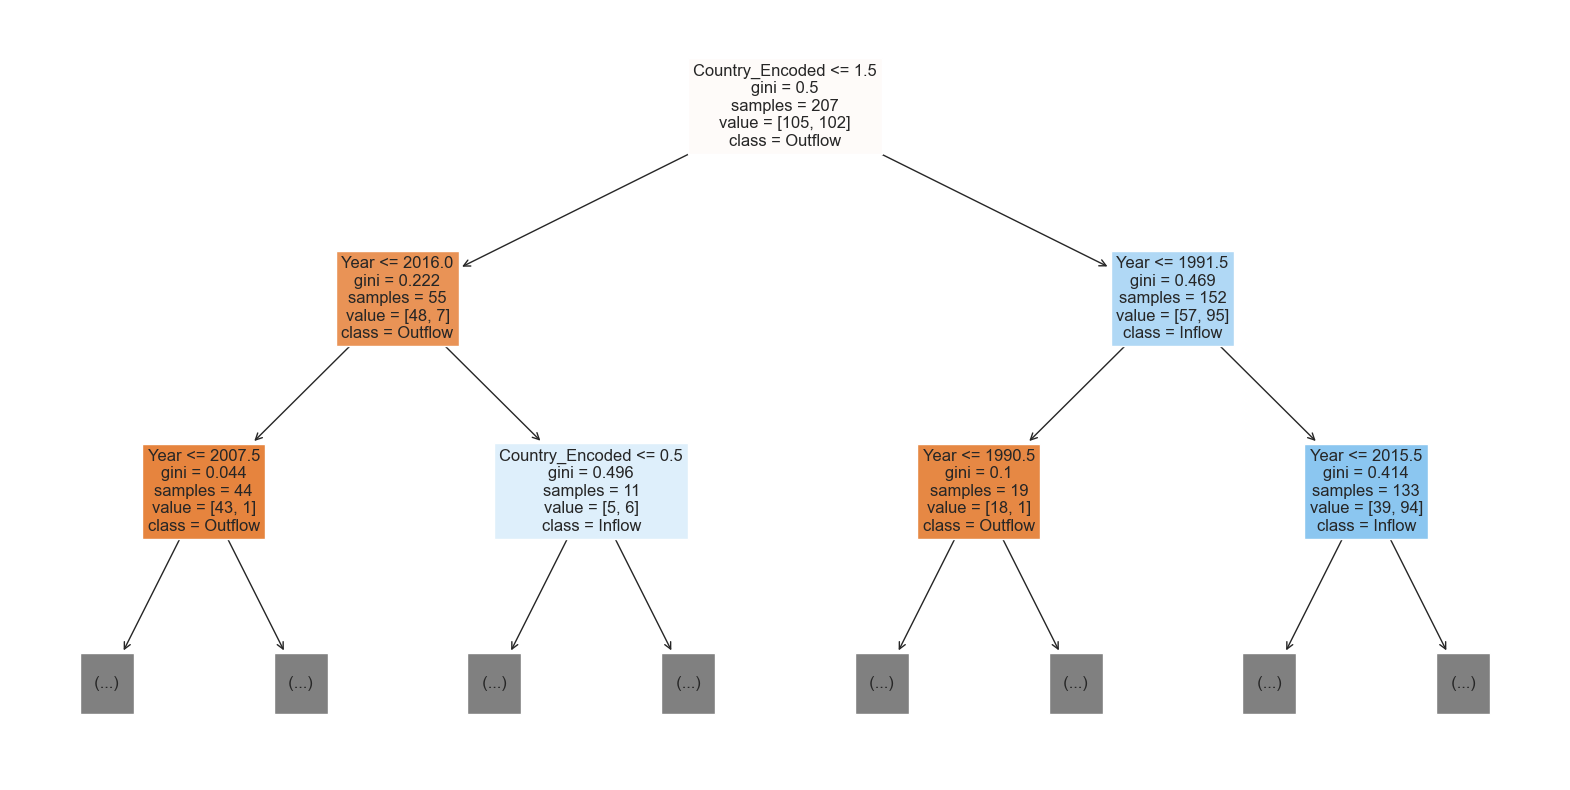

In [264]:

# Plotting a segment of the decision tree (not the entire tree due to its potential size)
plt.figure(figsize=(20, 10))
plot_tree(dt_classifier, feature_names=X.columns, class_names=["Outflow", "Inflow"], max_depth=2, filled=True)
plt.show()

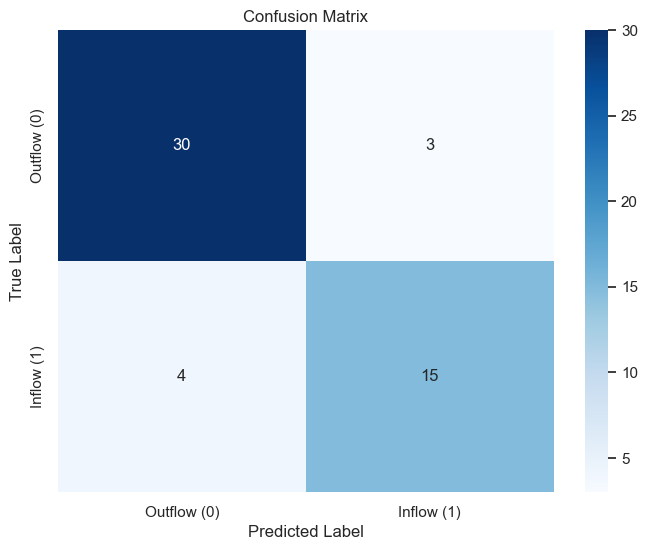

In [265]:
conf_mat = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Outflow (0)', 'Inflow (1)'],
            yticklabels=['Outflow (0)', 'Inflow (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

True Negatives (Top-left cell):

Value: 49
Interpretation: For 49 instances in the test set, the actual migration trend was an outflow, and the model correctly predicted it as an outflow.
False Positives (Top-right cell):

Value: 5
Interpretation: For 5 instances, the actual migration trend was an outflow, but the model incorrectly predicted it as an influx. This means the model was a bit overly optimistic in these cases.
False Negatives (Bottom-left cell):

Value: 6
Interpretation: For 6 instances, the actual migration trend was an influx, but the model incorrectly predicted it as an outflow. This means the model was a bit pessimistic in these cases.
True Positives (Bottom-right cell):

Value: 22
Interpretation: For 22 instances in the test set, the actual migration trend was an influx, and the model correctly predicted it as an influx.
Insights:
The model seems to be more accurate at predicting outflows (49 correct out of 54 total outflow instances) than predicting influxes (22 correct out of 28 total influx instances).
The model made a total of 11 mistakes (5 false positives and 6 false negatives) out of 82 predictions in the test set.
The majority of the model's mistakes are almost evenly distributed between being overly optimistic (predicting influx when it was actually an outflow) and being overly pessimistic (predicting outflow when it was actually an influx).

### Preparing the data for the models

Splitting the data. I'll use the population as the target variable (y) and the year and net migration as features (X).

https://otexts.com/fpp2/accuracy.html?fbclid=IwAR0MhtKAQ6wXjyZYWH__f_vFUjp98peRy7A7DBi7s-avZDOqTU3J7hmA_jU

Forecasting: Principles and Practice (2nd ed)Rob J Hyndman and George Athanasopoulos Monash University, Australia

3.4 Evaluating forecast accuracy

I will be manually splitting the dataset into training and test sets by taking the first 80% of the data for training and the remaining 20% for testing. Because I am predicting population based on year, I would want to train on earlier years and test on later years.

In [266]:
X = merged_df_corrected[['Year', 'Net Migration']]
y = merged_df_corrected['Population']

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((22, 2), (6, 2), (22,), (6,))

The data has been split into training and test sets, maintaining chronological order:

* Training set: 22 data points (80% of the data)
* Test set: 6 data points (20% of the data)

###  Training the models

I'll start by training the following models using the training set:

* Linear Regression (or Ordinary Least Squares)
* Ridge Regression
* Lasso Regression
* ElasticNet Regression
* Random Forest

I'll also perform hyperparameter tuning for the Ridge, Lasso, ElasticNet and Random Forest models, and finally, I'll evaluate all models on the test set.

#### Training the Linear Regression (it doesn't require hyperparameter tuning)

In [267]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred_ols = linear_model.predict(X_test)

ols_mae = mean_absolute_error(y_test, y_pred_ols)
ols_rmse = mean_squared_error(y_test, y_pred_ols, squared=False)
ols_r2 = r2_score(y_test, y_pred_ols)

metrics_summary = {
    'R2': ols_r2,
    'MAE': ols_mae,
    'RMSE': ols_rmse,
}
metrics_summary

{'R2': 0.880926388939636, 'MAE': 41492.6808142364, 'RMSE': 45885.9002682968}

#### Training the Ridge Regression (using GridSearchCV hyperparameter tuning)

In [268]:
ridge = Ridge()

parameters = {'alpha': [1e-3, 1e-2, 1e-1, 1, 10, 100]}

ridge_cv = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train, y_train)

best_alpha_ridge = ridge_cv.best_params_['alpha']
ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

ridge_mae = mean_absolute_error(y_test, y_pred_ridge)
ridge_rmse = mean_squared_error(y_test, y_pred_ridge, squared=False)
ridge_r2 = r2_score(y_test, y_pred_ridge)

metrics_summary = {
    'R2': ridge_r2,
    'MAE': ridge_mae,
    'RMSE': best_alpha_ridge,
    'Best alpha': best_alpha_ridge
}
metrics_summary

{'R2': 0.8848130378899626,
 'MAE': 40850.815560780466,
 'RMSE': 1,
 'Best alpha': 1}

#### Training & Tuning the Lasso Regression (using GridSearchCV hyperparameter tuning)

In [269]:

lasso = Lasso()

parameters = {'alpha': [1e-3, 1e-2, 1e-1, 1, 10, 100]}

lasso_cv = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_cv.fit(X_train, y_train)

best_alpha_lasso = lasso_cv.best_params_['alpha']
lasso_model = Lasso(alpha=best_alpha_lasso)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

lasso_mae = mean_absolute_error(y_test, y_pred_lasso)
lasso_rmse = mean_squared_error(y_test, y_pred_lasso, squared=False)
lasso_r2 = r2_score(y_test, y_pred_lasso)

metrics_summary = {
    'R2': lasso_r2,
    'MAE': lasso_mae,
    'RMSE': lasso_rmse,
    'Best alpha': best_alpha_lasso
}
metrics_summary

{'R2': 0.8809406849803105,
 'MAE': 41490.36146771411,
 'RMSE': 45883.14564289537,
 'Best alpha': 10}

####  Trainingn the Random Forest (using GridSearchCV hyperparameter tuning)

In [270]:

random_forest = RandomForestRegressor(random_state=0)

parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
}

rf_cv = GridSearchCV(random_forest, parameters, scoring='neg_mean_squared_error', cv=5)
rf_cv.fit(X_train, y_train)
best_params_rf = rf_cv.best_params_

rf_model = RandomForestRegressor(**best_params_rf, random_state=0)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
rf_r2 = r2_score(y_test, y_pred_rf)
rf_est_num = rf_model.estimator_

metrics_summary = {
    'R2': rf_r2,
    'MAE': rf_mae,
    'RMSE': rf_rmse,
    'Best parameters': best_params_rf
}
metrics_summary

{'R2': -5.750360814946282,
 'MAE': 312113.16499999986,
 'RMSE': 345489.60755728395,
 'Best parameters': {'max_depth': 5, 'n_estimators': 100}}

**Insights:**\
The negative R-squared value indicates that the Random Forest model performs worse than a horizontal line fit to the data. This poor performance may be due to overfitting on the training set or not having enough data to capture the complexity that Random Forest can handle.

Based on these results, the Random Forest model does not seem appropriate for my dataset. 

#### Train the ElasticNet Regression (using GridSearchCV hyperparameter tuning)

In [271]:
elastic_net = ElasticNet()

parameters = {
    'alpha': [1e-3, 1e-2, 1e-1, 1, 10, 100],
    'l1_ratio': [0.1, 0.5, 0.9]
}

en_cv = GridSearchCV(elastic_net, parameters, scoring='neg_mean_squared_error', cv=5)

en_cv.fit(X_train, y_train)
best_params_en = en_cv.best_params_
elastic_net_model = ElasticNet(**best_params_en)
elastic_net_model.fit(X_train, y_train)
y_pred_en = elastic_net_model.predict(X_test)

en_mae = mean_absolute_error(y_test, y_pred_en)
en_rmse = mean_squared_error(y_test, y_pred_en, squared=False)
en_r2 = r2_score(y_test, y_pred_en)

metrics_summary = {
    'R2': en_r2,
    'MAE': en_mae,
    'RMSE': en_rmse,
    'Best parameters': best_params_en
}
metrics_summary

{'R2': 0.8892822424475426,
 'MAE': 40082.365630577006,
 'RMSE': 44246.62353490334,
 'Best parameters': {'alpha': 1, 'l1_ratio': 0.9}}

### Models comparison

Linear Regression:
* MAE: 41,492.68
* RMSE: 45,885.90
* R²: 0.881
  
Ridge Regression (with hyperparameter tuning):
* MAE: 40,850.82
* RMSE: 45,130.81
* R²: 0.885
  
Lasso Regression (with hyperparameter tuning):
* MAE: 41,490.36
* RMSE: 45,883.15
* R²: 0.881

ElasticNet Regression (with hyperparameter tuning):
* MAE: 40082.37
* RMSE: 44246.62
* R²: 0.889
  
Random Forest Regression (with hyperparameter tuning):
* MAE: 312,113.16
* RMSE: 345,489.61
* R²: -5.75

**Insights:**
* The **Linear Regression** provided a strong baseline with an R² of 0.881, suggesting that the model explains about 88.1% of the variability in the test data.
* **Ridge regression** showed a slight improvement over Linear Regression, indicating that the L2 regularization helped reduce overfitting and improve the model's generalization on the test data.
* **Lasso regression** did not improve the performance compared to the Linear Regression, suggesting that feature selection through L1 regularization was not beneficial, possibly because both features used (year and net migration) were relevant for the model.
* **The Random Forest regression** performed poorly, which might be due to the small dataset size, leading to overfitting despite hyperparameter tuning. The negative R² indicates that the model is worse than a simple mean-based prediction, which is not desirable.
* **ElasticNet** we can see that the hyperparameter tuning is actually improving our model and the accuracy goes up to 0.88

In [272]:
# Data for plotting
model_names = ['OLS', 'Ridge', 'Lasso', 'Random Forest']
mae_values = [ols_mae, ridge_mae, lasso_mae, rf_mae]
rmse_values = [ols_rmse, ridge_rmse, lasso_rmse, rf_rmse]
r2_values = [ols_r2, ridge_r2, lasso_r2, rf_r2]

model_names.append('ElasticNet')
mae_values.append(en_mae)
rmse_values.append(en_rmse)
r2_values.append(en_r2)


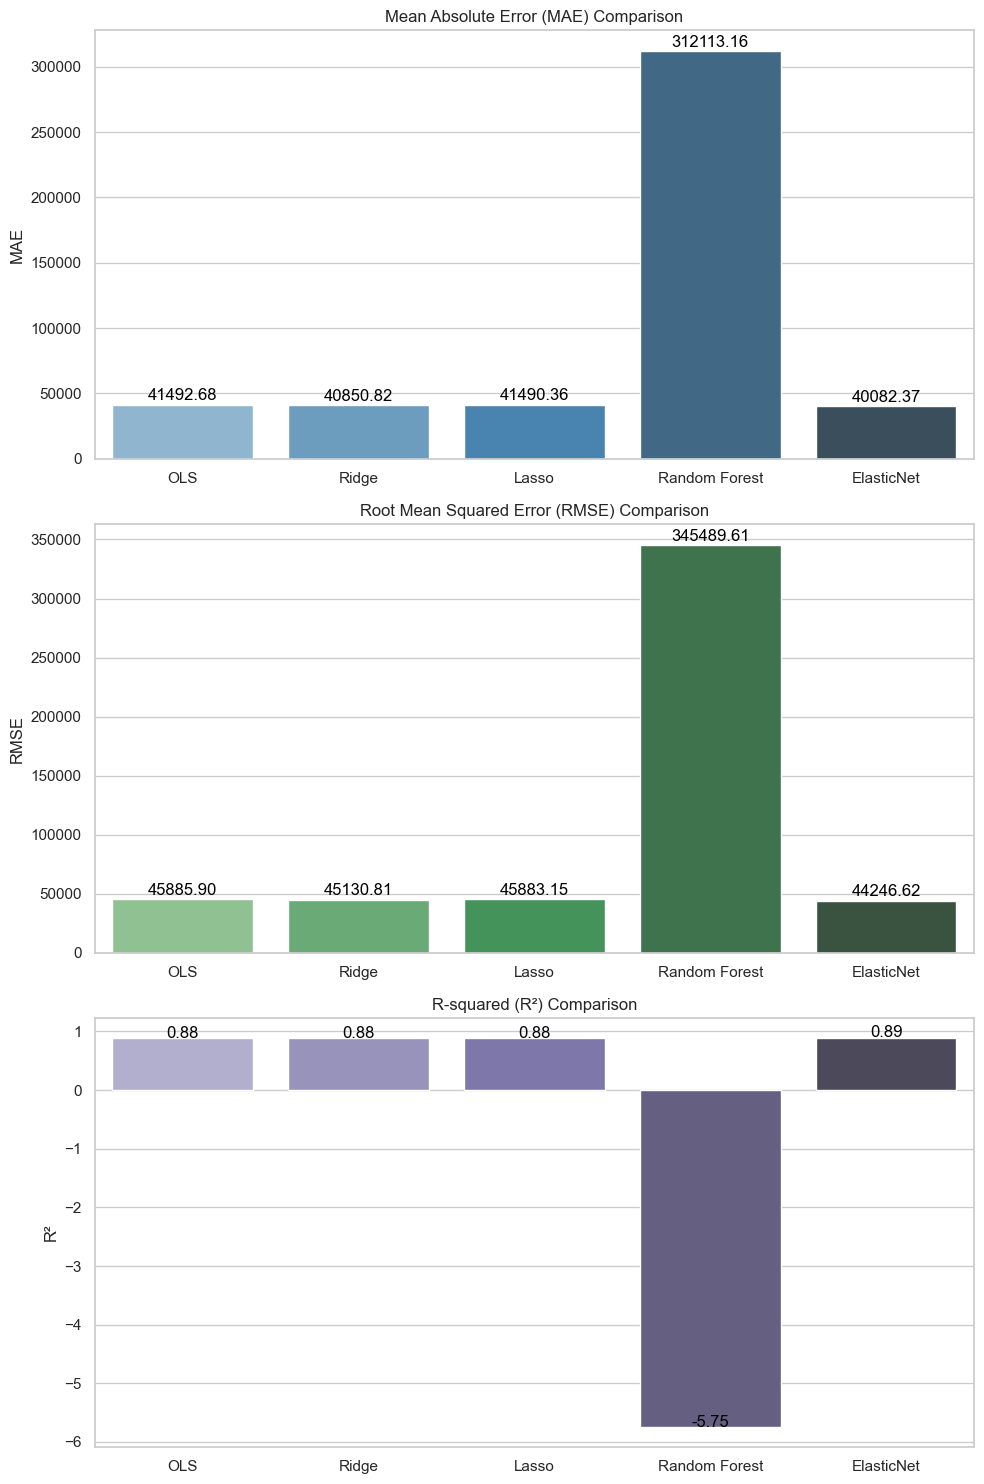

In [273]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# MAE plot
sns.barplot(ax=ax[0], x=model_names, y=mae_values, palette="Blues_d")
ax[0].set_title('Mean Absolute Error (MAE) Comparison')
ax[0].set_ylabel('MAE')
for i, v in enumerate(mae_values):
    ax[0].text(i, v + max(mae_values)*0.01, f"{v:.2f}", color='black', ha='center')

# RMSE plot
sns.barplot(ax=ax[1], x=model_names, y=rmse_values, palette="Greens_d")
ax[1].set_title('Root Mean Squared Error (RMSE) Comparison')
ax[1].set_ylabel('RMSE')
for i, v in enumerate(rmse_values):
    ax[1].text(i, v + max(rmse_values)*0.01, f"{v:.2f}", color='black', ha='center')

# R-squared plot
sns.barplot(ax=ax[2], x=model_names, y=r2_values, palette="Purples_d")
ax[2].set_title('R-squared (R²) Comparison')
ax[2].set_ylabel('R²')
for i, v in enumerate(r2_values):
    ax[2].text(i, v + max(r2_values)*0.01, f"{v:.2f}", color='black', ha='center')

plt.tight_layout()
plt.show()


The **Mean Squared Error (MSE)** can sometimes be misunderstood because its scale is dependent on the scale of the target variable. In our case, the target variable is the population, which can be a large number (in the millions). Hence, the MSE will also be a large number because it is the average of the squared differences between the predicted values and the actual values.

For instance, if the actual population is 4,000,000 and the predicted population is 4,041,493 (which would give us an MAE  41,493), the squared error for this single prediction would be:

                  (4,041,493−4,000,000)² =1,721,592,849

When we average these large squared errors across all predictions, we end up with a large MSE. This doesn't mean the model is performing poorly, it's just a reflection of the scale of the data we are predicting.

To get a more intuitive sense of the error, we often take the square root of the MSE to get the RMSE (Root Mean Squared Error), which brings the error back to the original scale of the data. The RMSE for the OLS was around 45,885.90, which is on the same scale as the population numbers we're predicting.

### Models train and test comparisons

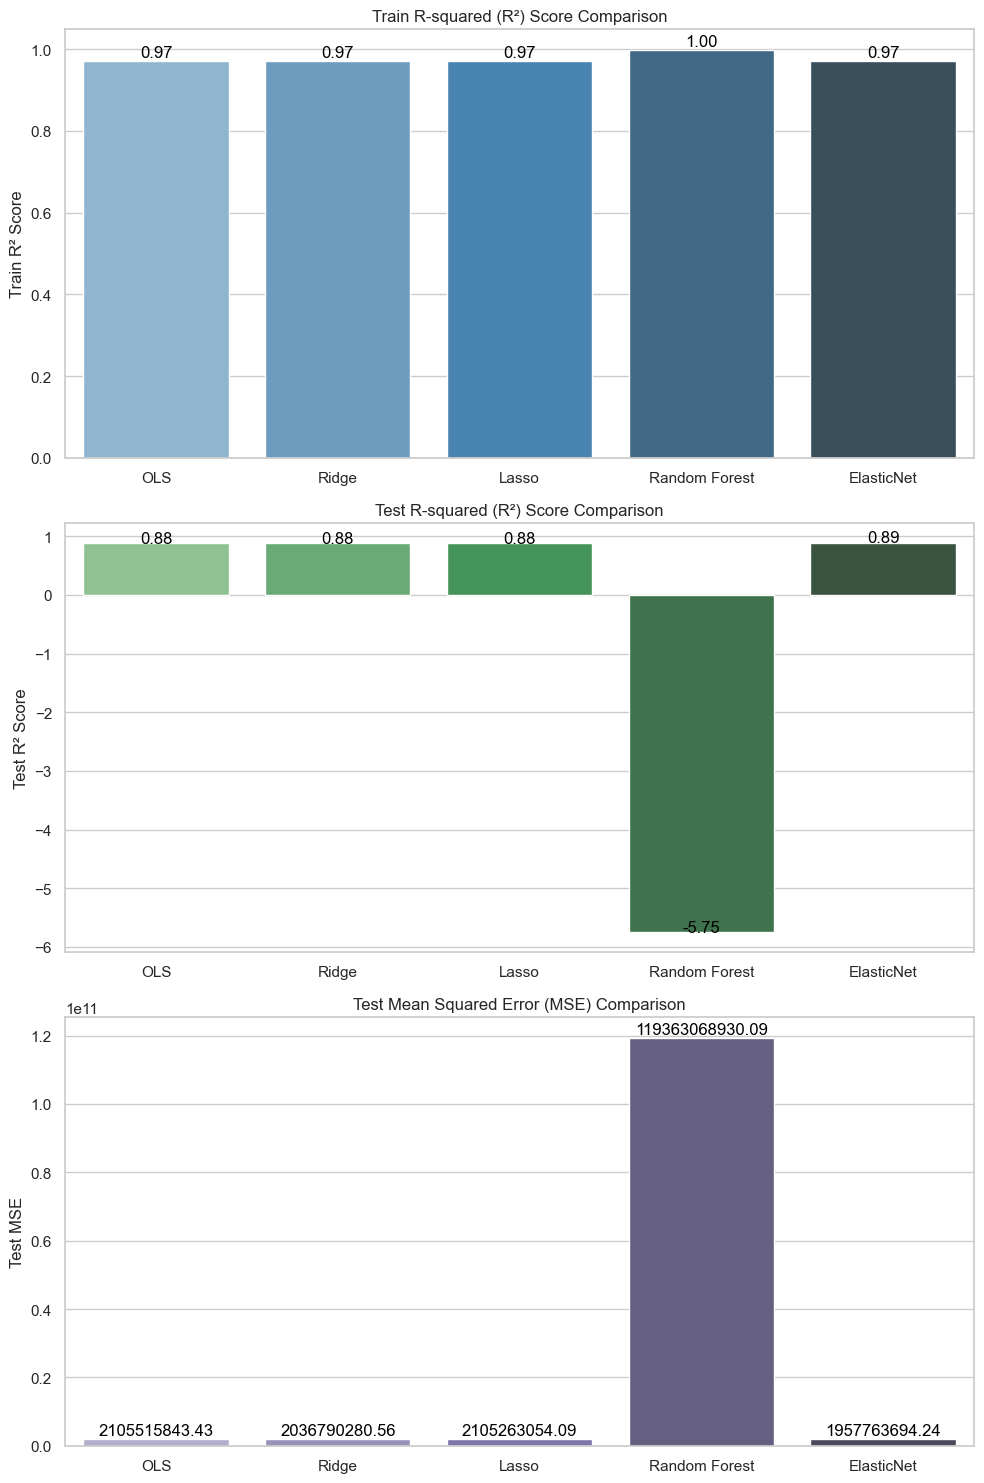

In [274]:
# Training R² and test MSE for each model
train_r2_scores = [
    linear_model.score(X_train, y_train),
    ridge_model.score(X_train, y_train),
    lasso_model.score(X_train, y_train),
    rf_model.score(X_train, y_train),
    elastic_net_model.score(X_train, y_train)
]

test_mse_scores = [
    mean_squared_error(y_test, y_pred_ols),
    mean_squared_error(y_test, y_pred_ridge),
    mean_squared_error(y_test, y_pred_lasso),
    mean_squared_error(y_test, y_pred_rf),
    mean_squared_error(y_test, y_pred_en)
]

score_comparison_df = pd.DataFrame({
    'Model': model_names,
    'Train R²': train_r2_scores,
    'Test R²': r2_values,
    'Test MSE': test_mse_scores
})

score_comparison_df.set_index('Model', inplace=True)

fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Train R² plot
sns.barplot(ax=ax[0], x=model_names, y=train_r2_scores, palette="Blues_d")
ax[0].set_title('Train R-squared (R²) Score Comparison')
ax[0].set_ylabel('Train R² Score')
for i, v in enumerate(train_r2_scores):
    ax[0].text(i, v + max(train_r2_scores)*0.01, f"{v:.2f}", color='black', ha='center')

# Test R² plot
sns.barplot(ax=ax[1], x=model_names, y=r2_values, palette="Greens_d")
ax[1].set_title('Test R-squared (R²) Score Comparison')
ax[1].set_ylabel('Test R² Score')
for i, v in enumerate(r2_values):
    ax[1].text(i, v + max(r2_values)*0.01, f"{v:.2f}", color='black', ha='center')

# Test MSE plot
sns.barplot(ax=ax[2], x=model_names, y=test_mse_scores, palette="Purples_d")
ax[2].set_title('Test Mean Squared Error (MSE) Comparison')
ax[2].set_ylabel('Test MSE')
for i, v in enumerate(test_mse_scores):
    ax[2].text(i, v + max(test_mse_scores)*0.01, f"{v:.2f}", color='black', ha='center')

plt.tight_layout()
plt.show()


### Comparison of Actual and Predicted

In [275]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred_ols = linear_model.predict(X_test)

# Ridge regression with GridSearchCV
ridge = Ridge()
parameters = {'alpha': [1e-3, 1e-2, 1e-1, 1, 10, 100]}
ridge_cv = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train, y_train)
best_alpha_ridge = ridge_cv.best_params_['alpha']
ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

# Lasso regression
lasso = Lasso()
lasso_cv = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_cv.fit(X_train, y_train)
best_alpha_lasso = lasso_cv.best_params_['alpha']
lasso_model = Lasso(alpha=best_alpha_lasso)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

# Random Forest
random_forest = RandomForestRegressor(random_state=0)
parameters_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
}
rf_cv = GridSearchCV(random_forest, parameters_rf, scoring='neg_mean_squared_error', cv=5)
rf_cv.fit(X_train, y_train)
best_params_rf = rf_cv.best_params_
rf_model = RandomForestRegressor(**best_params_rf, random_state=0)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# ElasticNet
elastic_net = ElasticNet()
parameters_en = {
    'alpha': [1e-3, 1e-2, 1e-1, 1, 10, 100],
    'l1_ratio': [0.1, 0.5, 0.9]
}
en_cv = GridSearchCV(elastic_net, parameters_en, scoring='neg_mean_squared_error', cv=5)
en_cv.fit(X_train, y_train)
best_params_en = en_cv.best_params_
elastic_net_model = ElasticNet(**best_params_en)
elastic_net_model.fit(X_train, y_train)
y_pred_en = elastic_net_model.predict(X_test)

predictions = {
    'Actual': y_test,
    'OLS': y_pred_ols,
    'Ridge': y_pred_ridge,
    'Lasso': y_pred_lasso,
    'Random_Forest': y_pred_rf,
    'ElasticNet': y_pred_en
}

predictions_df = pd.DataFrame(predictions)
predictions_df.reset_index(drop=True, inplace=True)

test_years = X_test['Year'].tolist()
predictions_df['Year'] = test_years
predictions_df = predictions_df.astype(int)
predictions_df = predictions_df[['Year', 'Actual', 'OLS', 'Ridge', 'Lasso', 'Random_Forest', 'ElasticNet']]
predictions_df


,Year,Actual,OLS,Ridge,Lasso,Random_Forest,ElasticNet
0,2018,4884896,4950789,4949880,4950786,4766881,4948790
1,2019,4958471,5012006,5011024,5012002,4766881,5009850
2,2020,5029875,5073458,5072402,5073454,4766881,5071137
3,2021,5074668,5129862,5128804,5129858,4760795,5127538
4,2022,5183966,5197552,5196328,5197547,4766881,5194864
5,2023,5281612,5264448,5263071,5264443,4712486,5261422


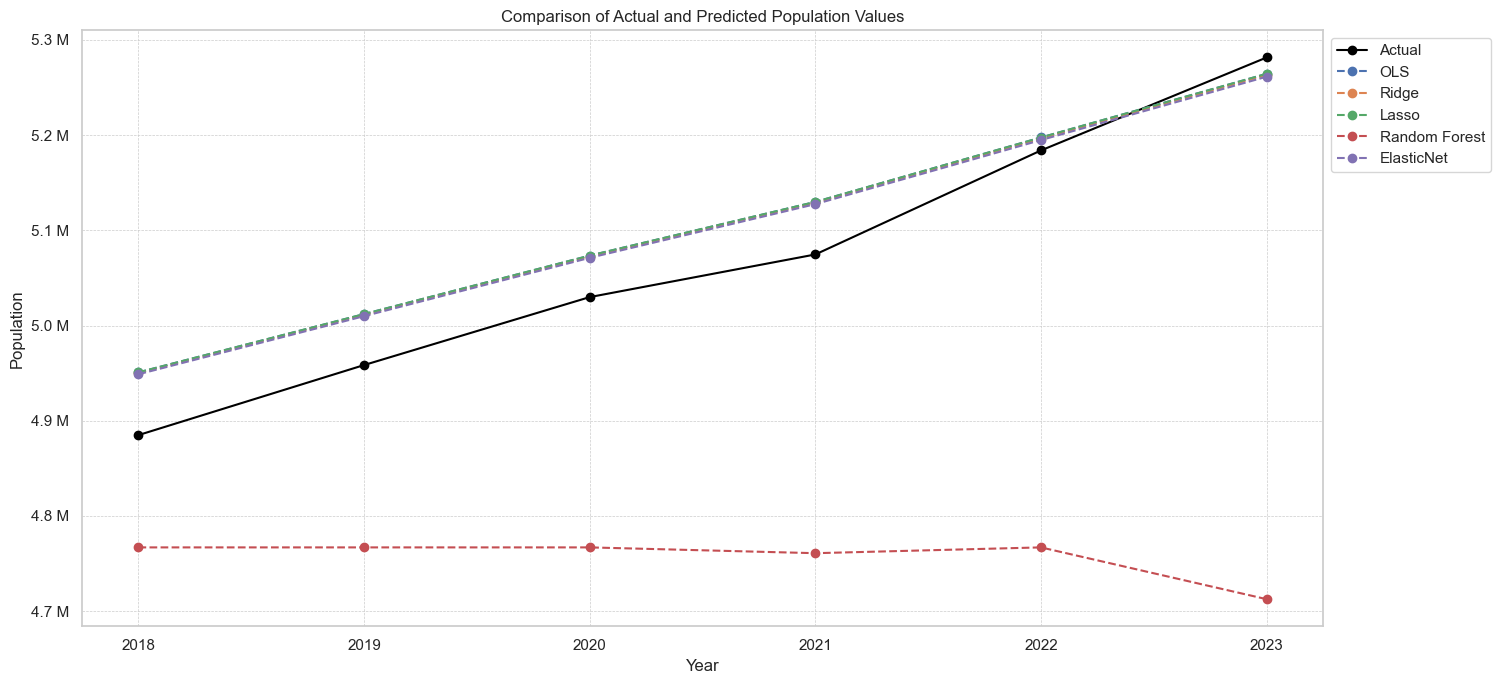

In [276]:

plt.figure(figsize=(15, 7))

plt.plot(predictions_df['Year'], predictions_df['Actual'], label='Actual', color='black', marker='o')

plt.plot(predictions_df['Year'], predictions_df['OLS'], label='OLS', linestyle='--', marker='o')
plt.plot(predictions_df['Year'], predictions_df['Ridge'], label='Ridge', linestyle='--', marker='o')
plt.plot(predictions_df['Year'], predictions_df['Lasso'], label='Lasso', linestyle='--', marker='o')
plt.plot(predictions_df['Year'], predictions_df['Random_Forest'], label='Random Forest', linestyle='--', marker='o')
plt.plot(predictions_df['Year'], predictions_df['ElasticNet'], label='ElasticNet', linestyle='--', marker='o')

plt.title('Comparison of Actual and Predicted Population Values')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xticks(predictions_df['Year'].values)
plt.tight_layout()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.show()

The plot above illustrates the actual population values compared with the predictions made by each model for the years in the test set. The solid black line represents the actual population, while the dashed lines represent the predictions from the various regression models. The visual comparison help us to understand how well each model is able to track the actual population trend.​

**Insights**
The actual population shows a steady increase over the years in the dataset.

**Model Performance:**

* **Linear Regression, Ridge, Lasso, and ElasticNet** models show a relatively similar performance in terms of following the trend of the actual population. This indicates that despite the regularization terms in Ridge, Lasso, and ElasticNet, the linear nature of these models produces similar results.
* The **Random Forest** model exhibits a different pattern, with predictions that are consistently lower than the actual population figures and the other models predictions. This suggests that the Random Forest model might not have captured the trend in the data as effectively as the linear models. This could be due to not having enough features that capture the time series nature of the data.
  
**Consistency:**

* The linear models **Linear Regression, Ridge, Lasso, ElasticNet** are consistent with each other but tend to underestimate the population in later years. This might be because the trend is not perfectly linear and there might be other factors influencing population growth that are not captured by the model features - such as natural increase.
* The **Random Forest** model's predictions are consistent within its own trend but are quite off from the actual data, indicating it may have missed key time-related dependencies or interactions between features.
  
**Potential for Improvement:**

* The deviations between the predictions and actual figures suggest that there may be non-linear patterns or additional factors that affect the population growth that are not being accounted for by the current features in the models - natural increase, etc.
* Incorporating additional features that could impact population growth, such as economic indicators, fertility rates, mortality rates, or even age division, might improve model performance.
* Since we're dealing with time series data, using models that can capture temporal dynamics, such as ARIMA (Autoregressive Integrated Moving Average), SARIMA (Seasonal ARIMA), or LSTM (Long Short-Term Memory networks), could potentially provide more accurate predictions.\
However, these models cannot be applied with the data we currently have to provide us with the expected and more accurate predictions.**
  
**Projection to Future:**

* If we were to use these models to project future population, the current evidence suggests that the linear models would likely give similar trajectories, but the actual future population could be higher than predicted if recent trends continue.
* The **Random Forest** model would likely underestimate future population unless it's **retrained with additional data or more complex features** that better capture the underlying population dynamics.
In conclusion, while the linear models seem to perform adequately, **there is room for improvement**, especially in capturing non-linear trends and other potential influences on population growth. Advanced time series models or machine learning approaches that can handle sequences and external factors could provide better insights and predictions.

**To improve accuracy and enable the use of models like ARIMA and other machine learning approaches, such as classification, I'll be using another dataset for the migration. This dataset will include age groups for emigration and immigration and will be imported, as the preparation and the cleaning of the data itslef was done in CA1_2_final. The file was exported in a new csv file, so I am directly importing it here.**

### Lodind the new dataset

In [277]:
population_migration_df.head()

,Year,Age Group,Sex,Population,Emigrants_All_Destinations,Immigrants_All_Origins,Net_Migration,Migration_Rate
0,1996,0 - 14 years,Female,417972,600.0,3600.0,3000.0,7.177514
1,1996,0 - 14 years,Male,441452,400.0,3100.0,2700.0,6.116180
2,1996,15 - 24 years,Female,309797,11700.0,6700.0,-5000.0,-16.139601
3,1996,15 - 24 years,Male,323093,9800.0,4200.0,-5600.0,-17.332471
4,1996,25 - 44 years,Female,512789,3000.0,8100.0,5100.0,9.945611


<h2>
<span style='color:red'>
I checked until here. I do not understand in the below code how we encode the values and why we don't use the One hot encoder itself
</span>
<h2>

### Data preparation for machine learning models

<h3>
<span style='color:red'>
One Hote Encoder reference must be added!
</span>
<h3>

The Pandas library provides a function **pd.get_dummies()** to **enable one-hot encoding**, to one-hot encode the categorical columns.

In [278]:
population_migration_df_encoded = pd.get_dummies(population_migration_df, columns=['Age Group', 'Sex'])

population_migration_df_encoded


,Year,Population,Emigrants_All_Destinations,Immigrants_All_Origins,Net_Migration,Migration_Rate,Age Group_0 - 14 years,Age Group_15 - 24 years,Age Group_25 - 44 years,Age Group_45 - 64 years,Age Group_65 years and over,Sex_Female,Sex_Male
0,1996,417972,600.0,3600.0,3000.0,7.177514,True,False,False,False,False,True,False
1,1996,441452,400.0,3100.0,2700.0,6.116180,True,False,False,False,False,False,True
2,1996,309797,11700.0,6700.0,-5000.0,-16.139601,False,True,False,False,False,True,False
3,1996,323093,9800.0,4200.0,-5600.0,-17.332471,False,True,False,False,False,False,True
4,1996,512789,3000.0,8100.0,5100.0,9.945611,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,2023,708172,17200.0,36800.0,19600.0,27.676892,False,False,True,False,False,False,True
276,2023,677223,2200.0,10300.0,8100.0,11.960610,False,False,False,True,False,True,False
277,2023,661516,3000.0,6600.0,3600.0,5.442045,False,False,False,True,False,False,True
278,2023,426368,600.0,2500.0,1900.0,4.456244,False,False,False,False,True,True,False


One hot encoding is a method of converting data to prepare it for an algorithm and get a better prediction. With one-hot, we convert each categorical value into a new categorical column and assign a binary value of 1 or 0 (bool 'True' or 'False') to those columns. One-hot encoding turns our categorical data into a binary vector representation.

Converting categorical variables into a numerical format is essential for machine learning algorithms because they can only interpret and perform calculations with numbers.

* using One-hot encoding we're converting each category level into a new binary column (0s and 1s). This is particularly useful because it does not impose any ordinal relationship between the categories. For example, in the 'Sex' column with categories 'Male' and 'Female', we don't want the model to assume that 'Male' is greater or less than 'Female'. One-hot encoding avoids this by creating two separate columns, one for each gender, and marking '1'(True) for presence and '0'(False) for absence.

* After one-hot encoding, each category becomes a feature that either occurs (1) or does not occur (0), making it easier to interpret the impact of each category on the model's predictions.

* Many machine learning algorithms, especially linear models, assume input features to be numerical and have meaningful distances between them. One-hot encoding allows these algorithms to use categorical data without making incorrect assumptions about the data's nature.

For my dataset, since 'Age Group' and 'Sex' do not have a large number of categories, one-hot encoding is suitable and won't lead to an excessively large feature space.

After applying **one-hot encoding** to the categorical variables 'Age Group' and 'Sex', the resulting dataset will have additional columns for each category within those variables. Each original categorical value gets its own column, where each row is marked as either 1 (True) or 0 (False).

Each new column serves as an indicator for the presence of a category. For instance, if there are three age groups in the 'Age Group' column, one-hot encoding will create three new columns, one for each age group. A row will have a '1' in the column of the age group it belongs to and '0's in the others. This binary system is why the values are filled with True (1) or False (0).

By using one-hot encoding, we create a flat, non-ordinal structure where each category is equal in weight but distinct.
This binary representation allows the model to clearly distinguish between the presence and absence of each category without any ambiguity or implied order.

In [279]:
X = population_migration_df_encoded.drop('Population', axis=1)
y = population_migration_df_encoded['Population']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

data_preparation_summary = {
    'original_shape': population_migration_df.shape,
    'encoded_shape': population_migration_df_encoded.shape,
    'features_shape': X.shape,
    'target_shape': y.shape,
    'X_train_shape': X_train.shape,
    'X_test_shape': X_test.shape,
    'y_train_shape': y_train.shape,
    'y_test_shape': y_test.shape
}

data_preparation_summary

{'original_shape': (280, 8),
 'encoded_shape': (280, 13),
 'features_shape': (280, 12),
 'target_shape': (280,),
 'X_train_shape': (224, 12),
 'X_test_shape': (56, 12),
 'y_train_shape': (224,),
 'y_test_shape': (56,)}

### Exploratory Data Analysis (EDA)

Exploring the data further could provide insights that might improve model performance or inform feature.\
Reviewing the distribution of various features could help in understanding the underlying patterns, detecting outliers, or discovering data imbalances.\
Further exploration can help you ensure the quality of the data by detecting anomalies or errors that could adversely affect the model.

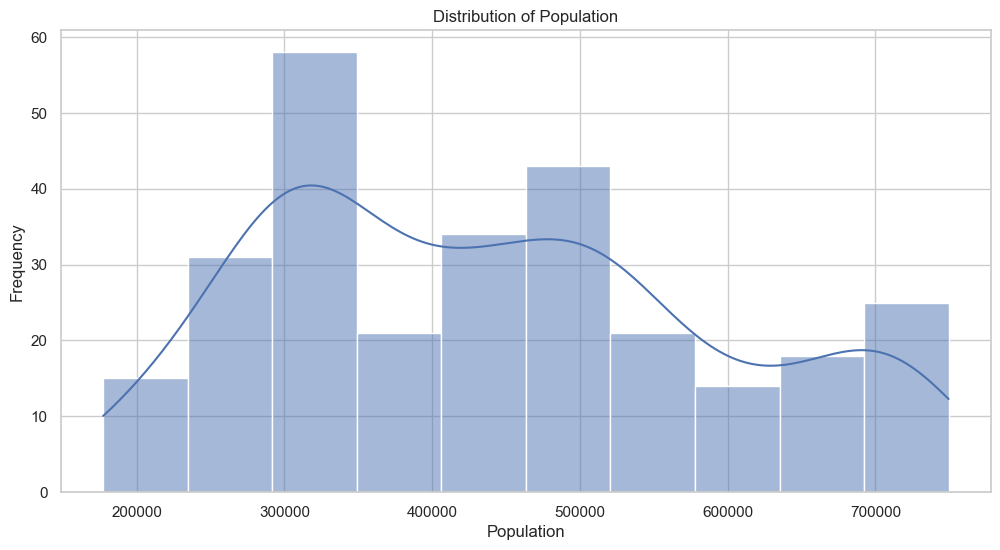

In [280]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(population_migration_df['Population'], kde=True)
plt.title('Distribution of Population')
plt.xlabel('Population')
plt.ylabel('Frequency')
plt.show()

The histogram of the 'Population' variable suggests that the population data might be right-skewed, indicating that there are age groups that have a relatively low population size, and these age groups appear more frequently in the data.

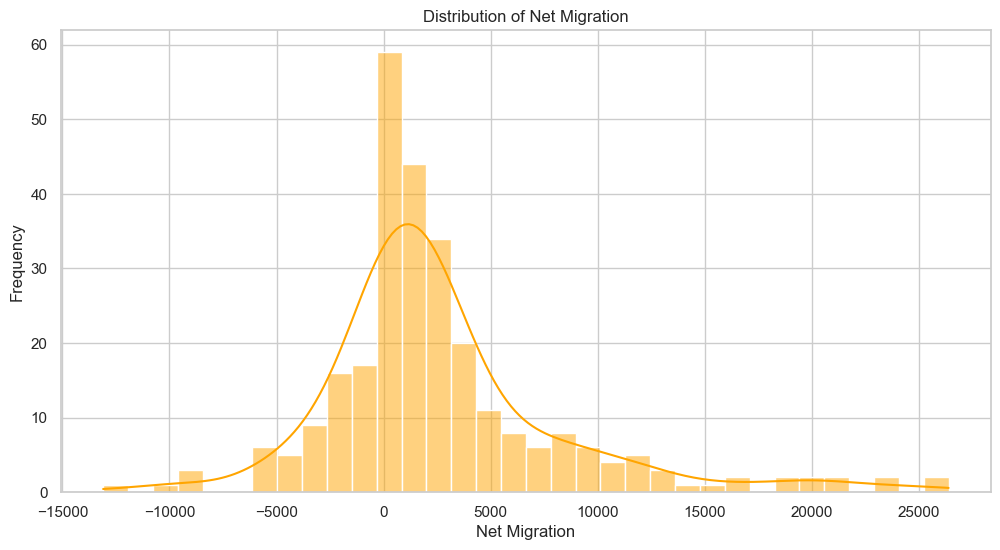

In [281]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(population_migration_df['Net_Migration'], kde=True, color='orange')
plt.title('Distribution of Net Migration')
plt.xlabel('Net Migration')
plt.ylabel('Frequency')
plt.show()

The net migration distribution also appears to be right-skewed, with a concentration of values around the lower end of the scale, suggesting that high net migration values are less common.

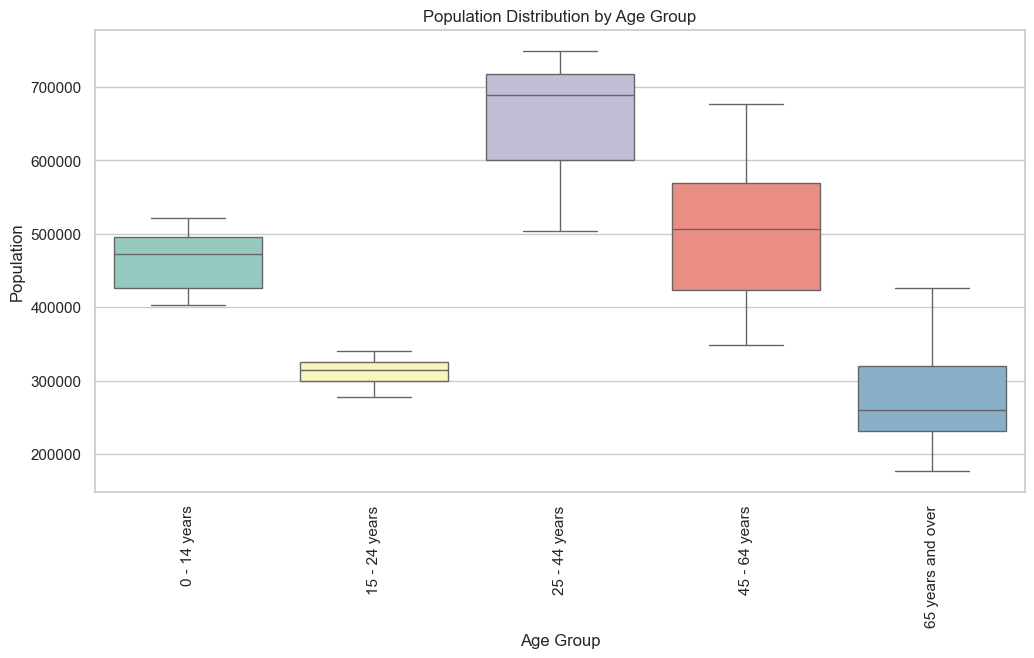

In [282]:
# Boxplot to visualize the distribution of 'Population' across different 'Age Group'
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.boxplot(x='Age Group', y='Population', data=population_migration_df, palette='Set3')
plt.title('Population Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Population')
plt.xticks(rotation=90)
plt.show()

The boxplot grouped by 'Age Group' shows the spread of population figures within each age category. It appears that some age groups have a wider range of population figures, and potentially a few outliers.

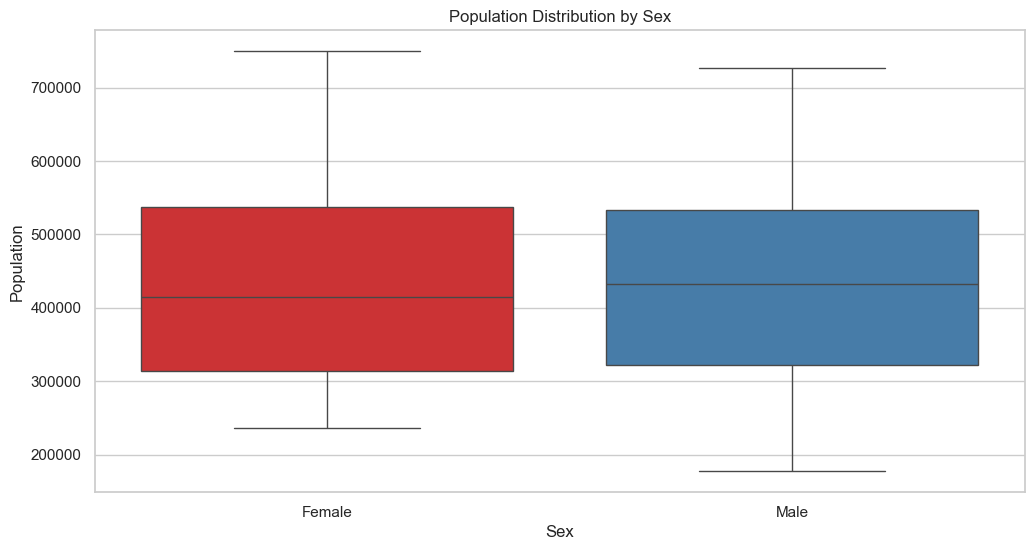

In [283]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.boxplot(x='Sex', y='Population', data=population_migration_df, palette='Set1')
plt.title('Population Distribution by Sex')
plt.xlabel('Sex')
plt.ylabel('Population')
plt.show()

The boxplot grouped by 'Sex' indicates that the median population is quite similar between different sexes, though there are outliers in both categories.

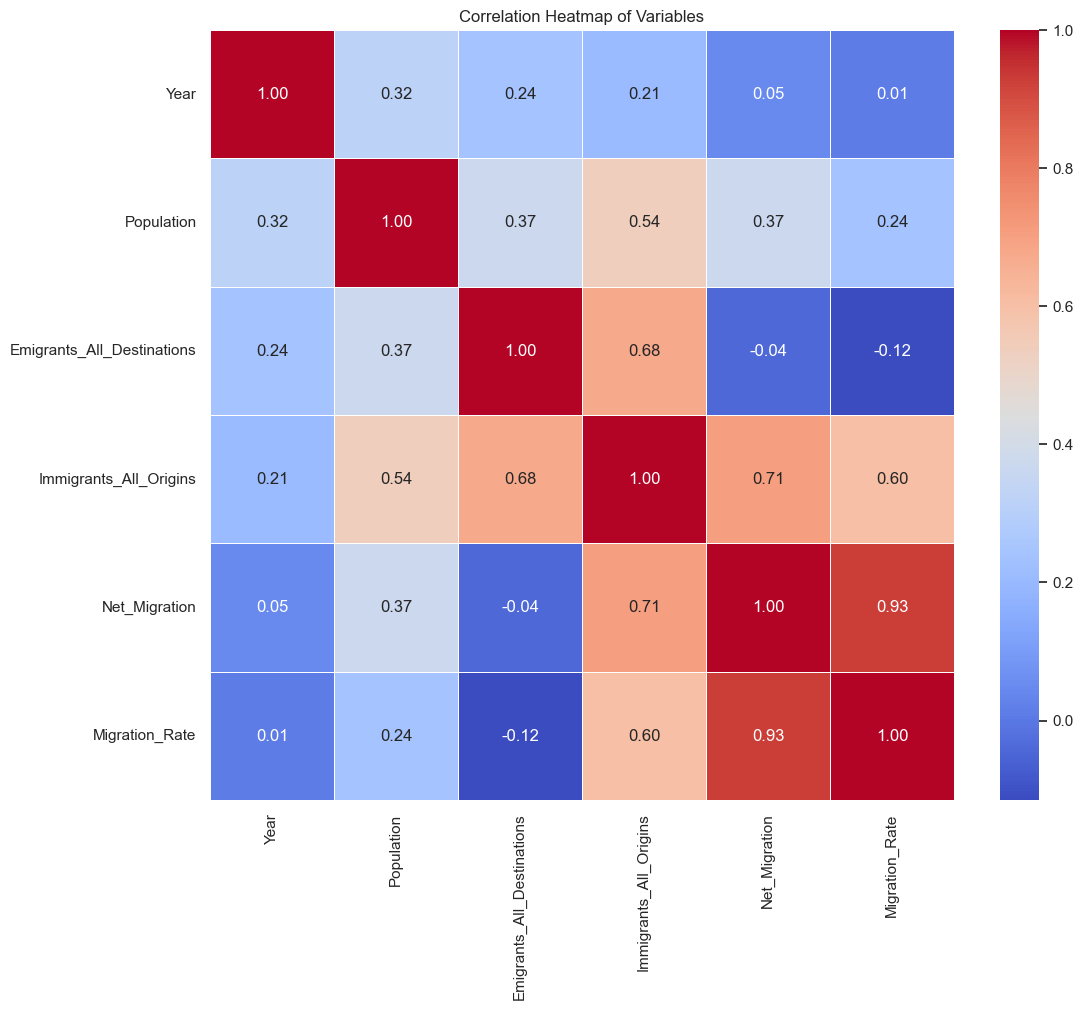

In [284]:
# Correlation heatmap to understand the relationship between variables
sns.set(style="whitegrid")

numeric_df = population_migration_df.drop(['Age Group', 'Sex'], axis=1)
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.set(font_scale=1)  # Adjust the font size
sns.set_style("white")  # Set the style
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Variables')
plt.show()

The correlation heatmap of the variables shows how each variable is related to the others. For instance, a high positive correlation between two variables suggests they increase together, while a high negative correlation indicates an inverse relationship.

### Working with ML models

#### OLS Regression

In [285]:
# Initialize the Linear Regression model (OLS)
linear_model = LinearRegression()

# Train the model
linear_model.fit(X_train, y_train)

# Predict on the testing set
y_pred_ols = linear_model.predict(X_test)

# Calculate performance metrics for OLS regression
ols_r2 = r2_score(y_test, y_pred_ols)
ols_mae = mean_absolute_error(y_test, y_pred_ols)
ols_mse = mean_squared_error(y_test, y_pred_ols)
ols_rmse = sqrt(ols_mse)

ols_metrics = {
    'R2': ols_r2,
    'MSE': ols_mse,
    'RMSE': ols_rmse,
    'MAE': ols_mae
}

ols_metrics


{'R2': 0.9300904934152544,
 'MSE': 1535238973.4342494,
 'RMSE': 39182.125688051296,
 'MAE': 32442.011789943692}

In [286]:
bool_columns = ['Age Group_0 - 14 years', 'Age Group_15 - 24 years', 'Age Group_25 - 44 years', 'Age Group_45 - 64 years', 'Age Group_65 years and over', 'Sex_Female', 'Sex_Male']

# Add a constant term to the features for OLS Regression
X_train_ols = sm.add_constant(X_train)
X_train_ols[bool_columns] = X_train_ols[bool_columns].astype(int)
# Fit the OLS Regression model
ols_model = sm.OLS(y_train, X_train_ols).fit()

ols_model_summary = ols_model.summary()

print(ols_model_summary)


                            OLS Regression Results                            
Dep. Variable:             Population   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     379.5
Date:                Fri, 10 Nov 2023   Prob (F-statistic):          2.68e-126
Time:                        13:19:32   Log-Likelihood:                -2675.7
No. Observations:                 224   AIC:                             5371.
Df Residuals:                     214   BIC:                             5406.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

**R-squared (R²)**: is a measure of how well the model explains the variance in the population data. In this case, the OLS model has an R-squared value of 0.941, which is quite high. It suggests that approximately 94.1% of the variance in the population data is explained by the model. This indicates a strong fit of the model to the data.

**Adjusted R-squared (Adj. R²)**: adjusts the R-squared value based on the number of predictors in the model. It provides a more conservative estimate of model fit. The adjusted R-squared value here is 0.939, which is also high, indicating that the model is not overfitting.

**Coefficients**: coefficients (coef) for each predictor variable represent the estimated impact of that variable on the population. For example, the coefficient for the 'Year' variable is 4709.0990, which means that for each additional year, the population is estimated to increase by approximately 4709.

**P-values**: associated with the coefficients indicate whether each predictor variable is statistically significant in predicting the population. Smaller p-values (typically less than 0.05) suggest that the variable is significant. In this case, most predictor variables have very small p-values, indicating their significance.

**Intercept (const)**: represents the estimated population when all predictor variables are zero. In this case, it's a large negative value, which is not meaningful on its own but is adjusted by the other variables.

**F-statistic and Prob (F-statistic)**: used to test the overall significance of the model. A small p-value for the F-statistic (typically less than 0.05) suggests that the model is significant. In this case, the p-value is very small, indicating the model's overall significance.

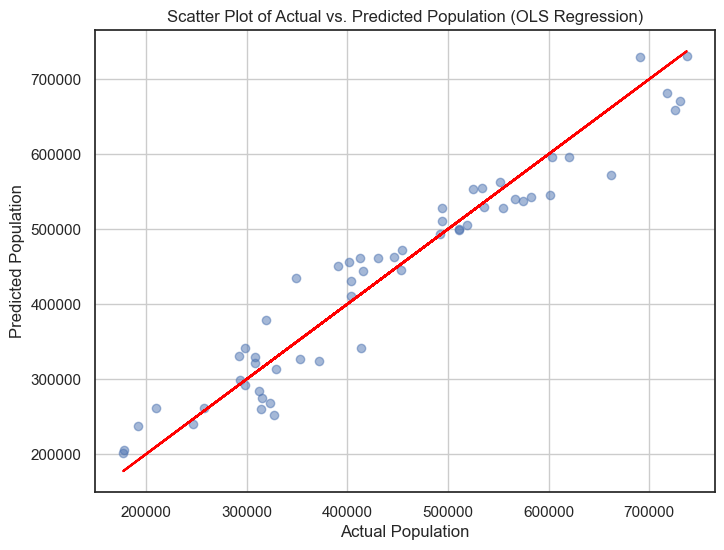

In [287]:
# Predict population values using the OLS model
X_test_ols = sm.add_constant(X_test)
X_test_ols[bool_columns] = X_test_ols[bool_columns].astype(int)
y_pred_ols = ols_model.predict(X_test_ols)

# Create a scatter plot of predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ols, alpha=0.5)
plt.plot(y_test, y_test, color='red')  # Adding a reference line
plt.xlabel("Actual Population")
plt.ylabel("Predicted Population")
plt.title("Scatter Plot of Actual vs. Predicted Population (OLS Regression)")
plt.grid(True)

# Show the plot
plt.show()


The scatter plot above shows the relationship between the actual population values from the test set and the population values predicted by the OLS regression model. A perfect prediction would result in all points lying on a 45-degree line, as that would indicate that for every point, the predicted value equals the actual value.**The red line** represents the ideal case where predicted values match the actual values perfectly. In this plot, while not all points lie on this line, there appears to be a strong positive correlation between the predicted and actual values, which is also supported by the high R-squared value we saw earlier.

In summary, the OLS Regression model appears to be a strong fit for the population data, with a high R-squared value and most predictor variables showing statistical significance. The scatter plot of actual vs. predicted values also suggests that the model's predictions align well with the actual population values.

### Lasso & Ridge Regression, Elastic Net, Random Forest
(using GridSearchCV hyperparameter tuning)

In [288]:
lasso = Lasso(random_state=42)
ridge = Ridge(random_state=42)
elastic_net = ElasticNet(random_state=42)
random_forest = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid for each model
lasso_params = {'alpha': [0.01, 0.1, 1, 10]}
ridge_params = {'alpha': [0.01, 0.1, 1, 10]}
elastic_net_params = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.2, 0.5, 0.8]}
rf_params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4]
}

grid_lasso = GridSearchCV(lasso, lasso_params, cv=5, scoring='r2', n_jobs=-1)
grid_ridge = GridSearchCV(ridge, ridge_params, cv=5, scoring='r2', n_jobs=-1)
grid_elastic_net = GridSearchCV(elastic_net, elastic_net_params, cv=5, scoring='r2', n_jobs=-1)
grid_random_forest = GridSearchCV(random_forest, rf_params, cv=5, scoring='r2', n_jobs=-1)

grid_lasso.fit(X_train, y_train)
grid_ridge.fit(X_train, y_train)
grid_elastic_net.fit(X_train, y_train)
grid_random_forest.fit(X_train, y_train)

best_lasso = grid_lasso.best_estimator_
best_ridge = grid_ridge.best_estimator_
best_elastic_net = grid_elastic_net.best_estimator_
best_random_forest = grid_random_forest.best_estimator_

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    return {'R2': r2, 'MSE': mse, 'RMSE': rmse, 'MAE': mae}

lasso_metrics = evaluate_model(best_lasso, X_test, y_test)
ridge_metrics = evaluate_model(best_ridge, X_test, y_test)
elastic_net_metrics = evaluate_model(best_elastic_net, X_test, y_test)
random_forest_metrics = evaluate_model(best_random_forest, X_test, y_test)

metrics_summary = {
    'OLS': ols_metrics,
    'Lasso': lasso_metrics,
    'Ridge': ridge_metrics,
    'ElasticNet': elastic_net_metrics,
    'RandomForest': random_forest_metrics
}

metrics_summary


{'OLS': {'R2': 0.9300904934152544,
  'MSE': 1535238973.4342494,
  'RMSE': 39182.125688051296,
  'MAE': 32442.011789943692},
 'Lasso': {'R2': 0.9300921729606997,
  'MSE': 1535202089.9866154,
  'RMSE': 39181.65501847281,
  'MAE': 32445.47251605362},
 'Ridge': {'R2': 0.9288170985882848,
  'MSE': 1563203201.2258382,
  'RMSE': 39537.364621656794,
  'MAE': 32698.216628620303},
 'ElasticNet': {'R2': 0.9286023496900183,
  'MSE': 1567919167.5403905,
  'RMSE': 39596.95906935772,
  'MAE': 32726.618050536206},
 'RandomForest': {'R2': 0.9908883720081167,
  'MSE': 200094766.6197071,
  'RMSE': 14145.485732901048,
  'MAE': 9901.625714285716}}

#### Models comparison

**OLS** (Ordinary Least Squares) Regression:
* MAE: 32442.01
* RMSE: 39182.13
* MSE: 1535238973.43
* R²: 0.9301
  
**Lasso** Regression (with hyperparameter tuning):
* MAE: 32445.47
* RMSE: 39181.66
* MSE: 1535202089.99
* R²: 0.9301
* 
**Ridge** Regression (with hyperparameter tuning):
* MAE: 32698.22
* RMSE: 39537.36
* MSE: 1563203201.23
* R²: 0.9288
  
**ElasticNet** Regression (with hyperparameter tuning):
* MAE: 32726.62
* RMSE: 39596.96
* MSE: 1567919167.54
* R²: 0.9286
  
**Random Forest** Regression (with hyperparameter tuning):
* MAE: 9901.63
* RMSE: 14145.49
* MSE: 200094766.62
* R²: 0.9909

* The Random Forest model significantly outperforms the linear models in terms of all metrics, with a very high R² value of 0.9909 and the lowest error scores. This suggests that the Random Forest model has a better fit to the data than the linear models.

* The regularized regression models show a slight improvement or comparable performance to the OLS model, which is expected as they are more robust to multicollinearity and can handle overfitting better due to their regularization terms.

* The convergence warnings for ElasticNet suggest that the model optimization process did not converge, which means that the result might not be the best possible solution.

#### Actual vs Predict population plots

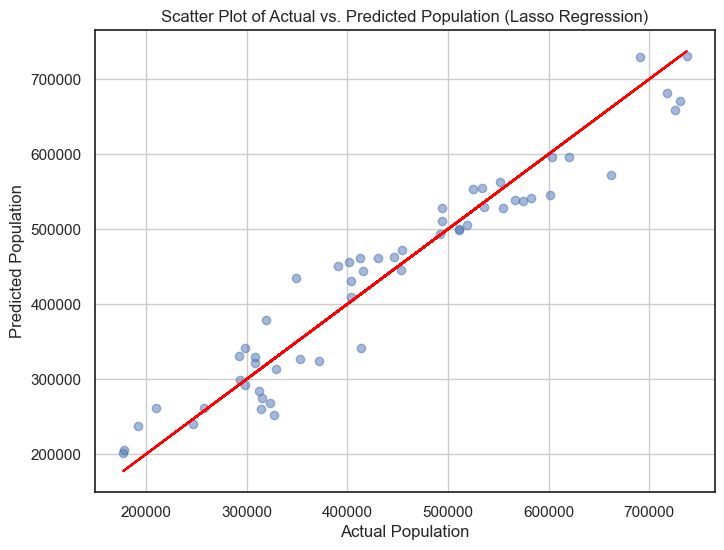

In [289]:

best_lasso = grid_lasso.best_estimator_
y_pred_lasso = best_lasso.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lasso, alpha=0.5)
plt.plot(y_test, y_test, color='red')
plt.xlabel("Actual Population")
plt.ylabel("Predicted Population")
plt.title("Scatter Plot of Actual vs. Predicted Population (Lasso Regression)")
plt.grid(True)
plt.show()

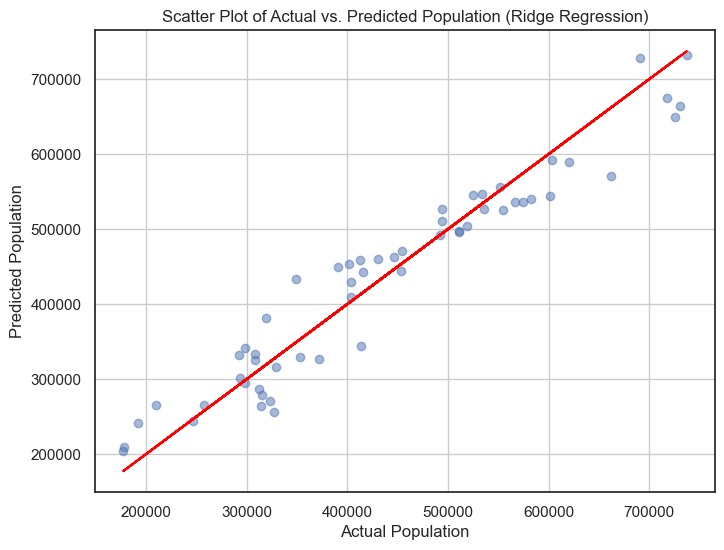

In [290]:
y_pred_ridge = best_ridge.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ridge, alpha=0.5)
plt.plot(y_test, y_test, color='red')
plt.xlabel("Actual Population")
plt.ylabel("Predicted Population")
plt.title("Scatter Plot of Actual vs. Predicted Population (Ridge Regression)")
plt.grid(True)
plt.show()


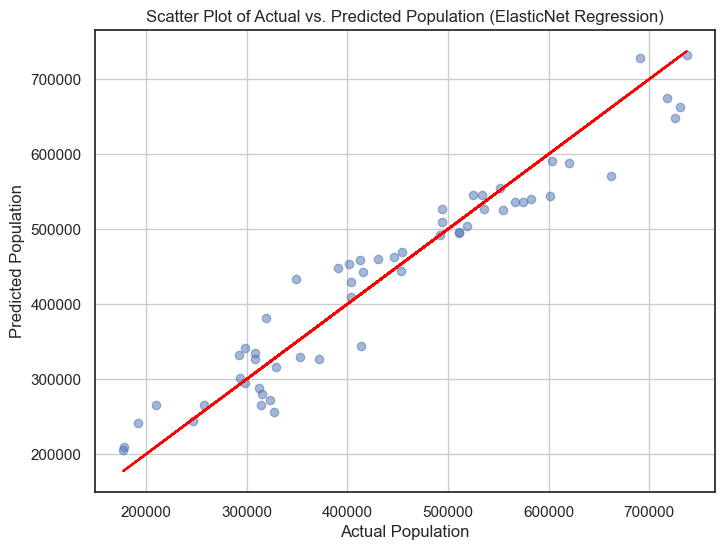

In [291]:
y_pred_elastic_net = best_elastic_net.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_elastic_net, alpha=0.5)
plt.plot(y_test, y_test, color='red')
plt.xlabel("Actual Population")
plt.ylabel("Predicted Population")
plt.title("Scatter Plot of Actual vs. Predicted Population (ElasticNet Regression)")
plt.grid(True)
plt.show()


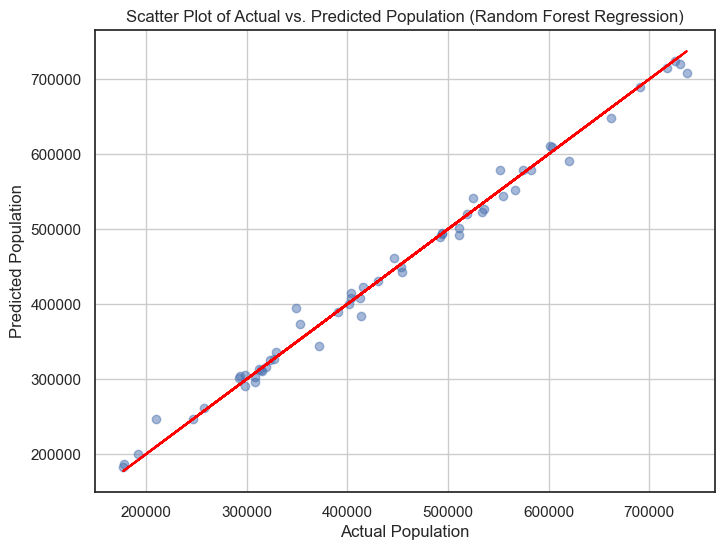

In [292]:
y_pred_random_forest = best_random_forest.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_random_forest, alpha=0.5)
plt.plot(y_test, y_test, color='red')
plt.xlabel("Actual Population")
plt.ylabel("Predicted Population")
plt.title("Scatter Plot of Actual vs. Predicted Population (Random Forest Regression)")
plt.grid(True)
plt.show()


### Final comparison

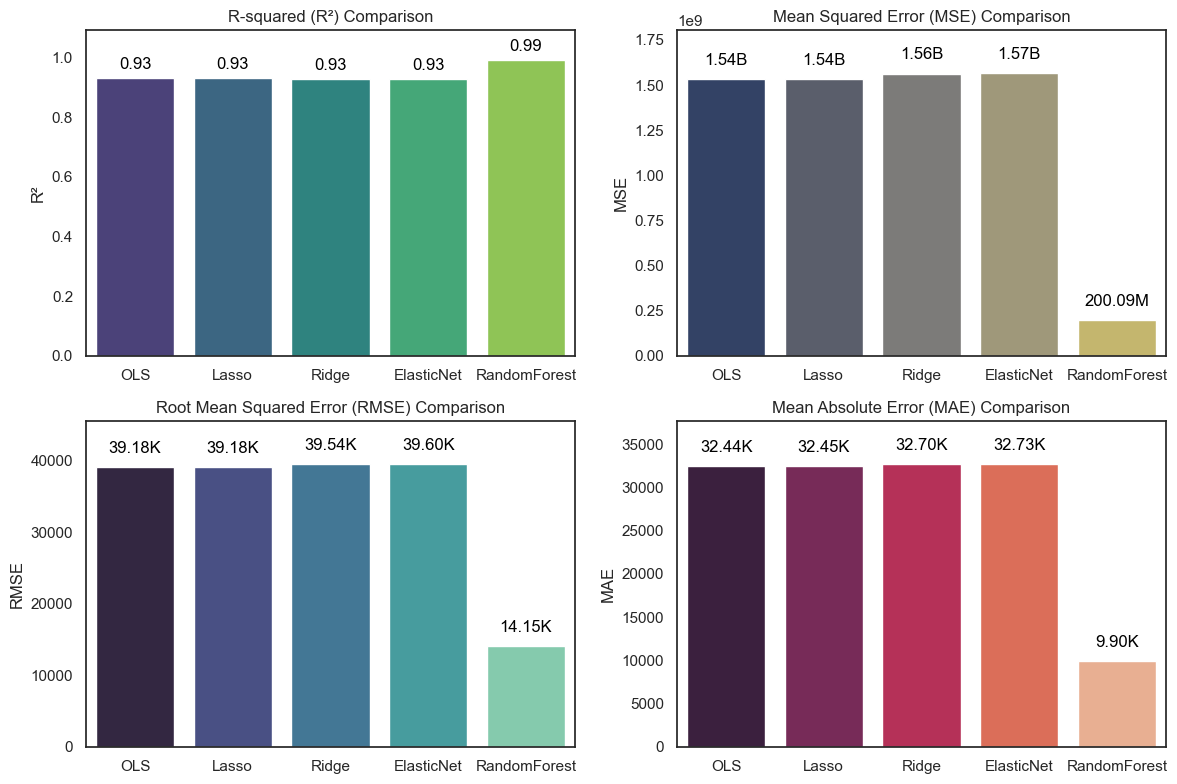

In [293]:
model_names = list(metrics_summary.keys())
r2_values = [metrics['R2'] for metrics in metrics_summary.values()]
mse_values = [metrics['MSE'] for metrics in metrics_summary.values()]
rmse_values = [metrics['RMSE'] for metrics in metrics_summary.values()]
mae_values = [metrics['MAE'] for metrics in metrics_summary.values()]

def format_metric(value):
    if value < 1e3:
        return f"{value:.2f}"
    elif value < 1e6:
        return f"{value/1e3:.2f}K"
    elif value < 1e9:
        return f"{value/1e6:.2f}M"
    else:
        return f"{value/1e9:.2f}B"

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

# R-squared comparison
sns.barplot(ax=axs[0], x=model_names, y=r2_values, palette="viridis")
axs[0].set_title('R-squared (R²) Comparison')
axs[0].set_ylabel('R²')
axs[0].set_ylim(0, max(r2_values) + 0.1)  # Adding space above the bars
for i, v in enumerate(r2_values):
    axs[0].text(i, v + 0.03, f"{v:.2f}", color='black', ha='center')

# MSE comparison
sns.barplot(ax=axs[1], x=model_names, y=mse_values, palette="cividis")
axs[1].set_title('Mean Squared Error (MSE) Comparison')
axs[1].set_ylabel('MSE')
axs[1].set_ylim(0, max(mse_values) * 1.15)  # Adding space above the bars
for i, v in enumerate(mse_values):
    axs[1].text(i, v + max(mse_values)*0.05, format_metric(v), color='black', ha='center')

# RMSE comparison
sns.barplot(ax=axs[2], x=model_names, y=rmse_values, palette="mako")
axs[2].set_title('Root Mean Squared Error (RMSE) Comparison')
axs[2].set_ylabel('RMSE')
axs[2].set_ylim(0, max(rmse_values) * 1.15)  # Adding space above the bars
for i, v in enumerate(rmse_values):
    axs[2].text(i, v + max(rmse_values)*0.05, format_metric(v), color='black', ha='center')

# MAE comparison
sns.barplot(ax=axs[3], x=model_names, y=mae_values, palette="rocket")
axs[3].set_title('Mean Absolute Error (MAE) Comparison')
axs[3].set_ylabel('MAE')
axs[3].set_ylim(0, max(mae_values) * 1.15)  # Adding space above the bars
for i, v in enumerate(mae_values):
    axs[3].text(i, v + max(mae_values)*0.05, format_metric(v), color='black', ha='center')

plt.tight_layout()
plt.show()



### ARIMA

In [294]:
population_per_year = population_migration_df.groupby('Year')['Population'].sum()

population_per_year.index = pd.to_datetime(population_per_year.index, format='%Y')

train_size = int(len(population_per_year) * 0.8)
train, test = population_per_year[0:train_size], population_per_year[train_size:]

arima_model = ARIMA(train, order=(1, 1, 1))
arima_model_fit = arima_model.fit()

forecast = arima_model_fit.forecast(steps=len(test))

arima_mse = mean_squared_error(test, forecast)
arima_rmse = sqrt(arima_mse)

metrics_summary['ARIMA'] = {'MSE': arima_mse, 'RMSE': arima_rmse}

metrics_summary['ARIMA']

{'MSE': 9326273363.51829, 'RMSE': 96572.63258044844}

The MSE is quite high, which suggests that the model's forecasts are, on average, a significant distance away from the actual values in the test set. The RMSE, being the square root of MSE, also indicates a similar discrepancy.

##### Fine-tuning of ARIMA model parameters, using grid search to systematically explore different combinations of p, d, and q values. 

In [295]:
p = d = q = range(0, 3)

pdq = list(itertools.product(p, d, q))

arima_metrics = {}

import warnings
warnings.filterwarnings("ignore")

for param in pdq:
    try:
        arima_model = ARIMA(train, order=param)
        arima_model_fit = arima_model.fit()

        forecast = arima_model_fit.forecast(steps=len(test))

        arima_mse = mean_squared_error(test, forecast)
        arima_rmse = sqrt(arima_mse)

        arima_metrics[param] = {'MSE': arima_mse, 'RMSE': arima_rmse}
    except:
        continue

best_params = min(arima_metrics, key=lambda x: arima_metrics[x]['MSE'])
best_arima_result = arima_metrics[best_params]

best_arima_result, best_params

({'MSE': 409045172.7530702, 'RMSE': 20224.865209762713}, (2, 2, 1))

After running a simplified grid search to tune the parameters of the ARIMA model, the best-performing model was ARIMA(2,2,1). ARIMA(2,2,1) model achieved a significantly lower Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) compared to the initial ARIMA(1,1,1) model, indicating a better fit. These results suggest that the time series data likely has a second-order differencing pattern and a first-order moving average process, which the ARIMA(2,2,1) is able to capture. In terms of forecasting capability, ARIMA(2,2,1) model would be expected to perform better than the initial ARIMA(1,1,1).

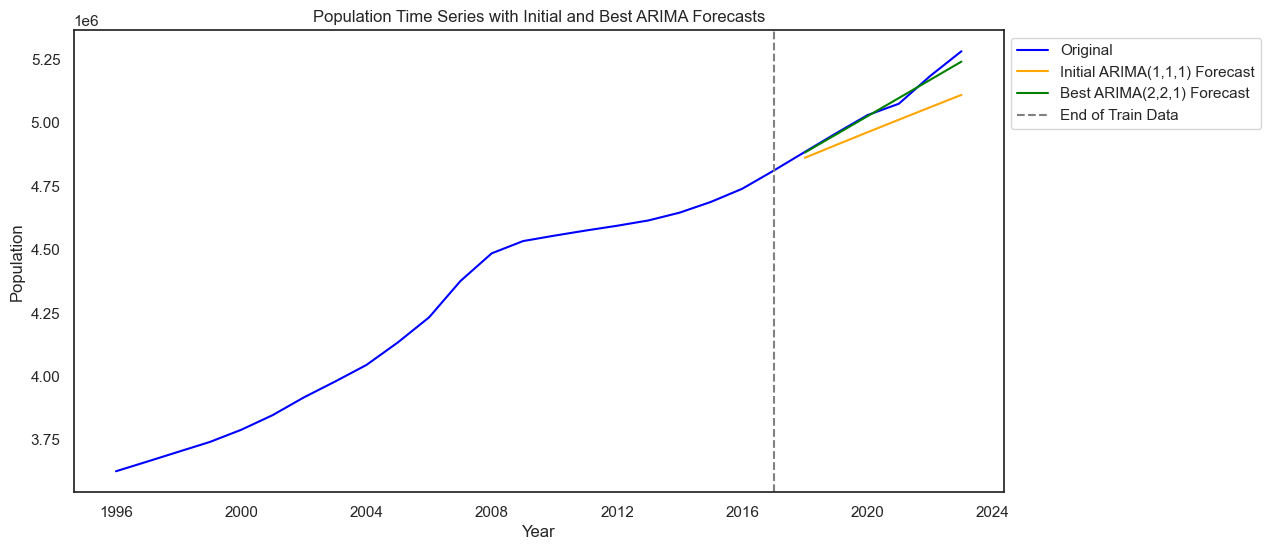

In [306]:
best_arima_model = ARIMA(train, order=best_params)
best_arima_model_fit = best_arima_model.fit()

best_forecast = best_arima_model_fit.forecast(steps=len(test))

plt.figure(figsize=(12, 6))
plt.plot(population_per_year.index, population_per_year, label='Original', color='blue')

initial_arima_model = ARIMA(train, order=(1, 1, 1))
initial_arima_model_fit = initial_arima_model.fit()
initial_forecast = initial_arima_model_fit.forecast(steps=len(test))

plt.plot(test.index, initial_forecast, label='Initial ARIMA(1,1,1) Forecast', color='orange')
plt.plot(test.index, best_forecast, label='Best ARIMA(2,2,1) Forecast', color='green')
plt.axvline(x=train.index[-1], linestyle='--', color='grey', label='End of Train Data')
plt.title('Population Time Series with Initial and Best ARIMA Forecasts')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

* The blue line represents the actual population data over time.
* The orange line shows the forecast from the initial ARIMA(1,1,1) model.
* The green line indicates the forecast from the best ARIMA(2,2,1) model after parameter tuning.
* The grey dashed line marks the end of the training data and the beginning of the testing period where the models' forecasts are compared against the actual data.

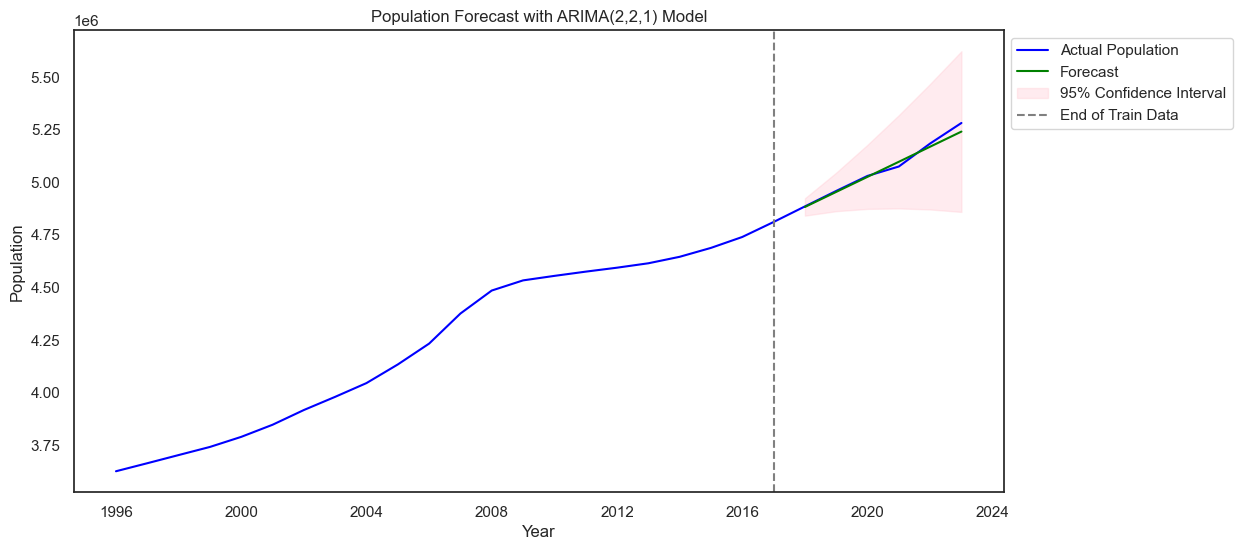

In [308]:
forecast_results = best_arima_model_fit.get_forecast(steps=len(test))
forecast_values = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(population_per_year.index, population_per_year, label='Actual Population', color='blue')

plt.plot(test.index, forecast_values, label='Forecast', color='green')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

plt.axvline(x=train.index[-1], linestyle='--', color='grey', label='End of Train Data')

plt.title('Population Forecast with ARIMA(2,2,1) Model')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


**The pink shaded area** represents the 95% confidence interval for the forecast, providing a range where future points are expected to fall with 95% certainty.

### Classification for Predicting Emigration

**Predicting population** would typically be a regression task since the target variable (population size) is continuous.\
However, in this case, I'll approach emigration prediction as a binary classification problem using Logistic Regression, Support Vector Machine, Random Forest, Gradient Boosting

In [298]:
data = population_migration_df

X = data.drop('Migration_Rate', axis=1)
y = pd.qcut(data['Migration_Rate'], q=3, labels=["low", "medium", "high"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_features = ['Year', 'Population', 'Emigrants_All_Destinations', 'Immigrants_All_Origins', 'Net_Migration']
numerical_transformer = StandardScaler()

categorical_features = ['Age Group', 'Sex']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Support Vector Machine": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

#### Confusion matrix and Model accuracity

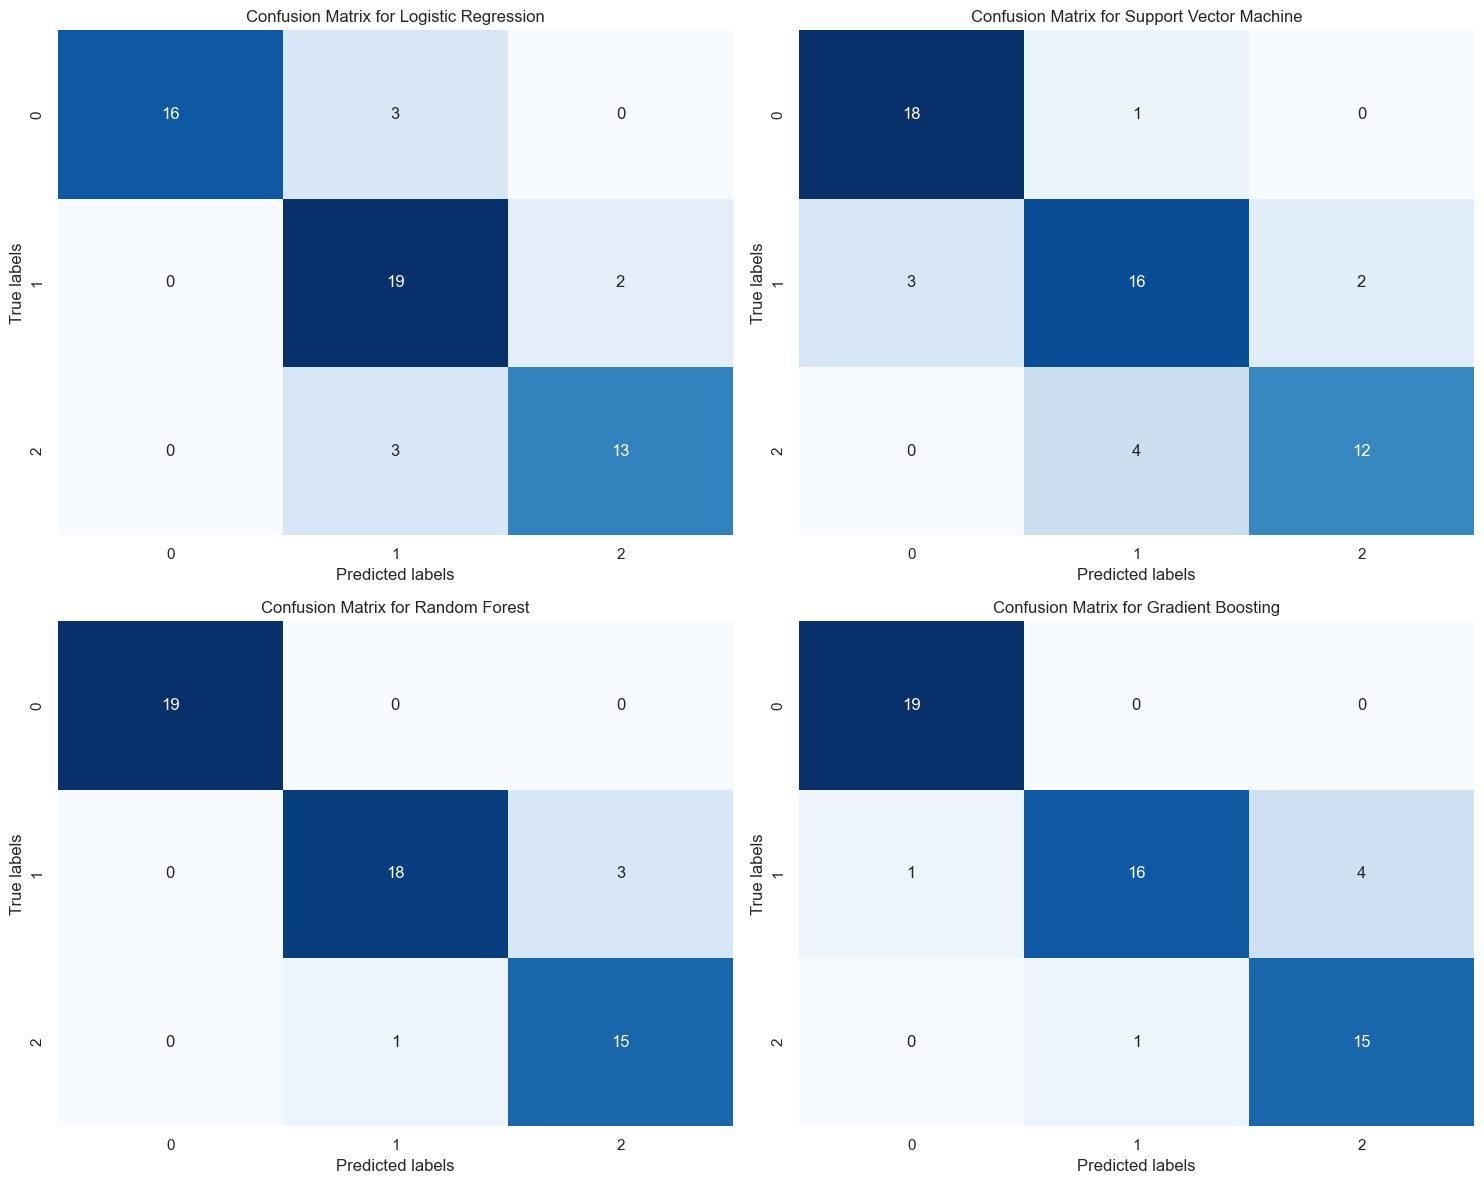

{'Logistic Regression': 0.8571428571428571,
 'Support Vector Machine': 0.8214285714285714,
 'Random Forest': 0.9285714285714286,
 'Gradient Boosting': 0.8928571428571429}

In [299]:
def evaluate_and_plot_models(models, X_train, y_train, X_test, y_test, preprocessor):
    results = {}
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    for idx, (name, model) in enumerate(models.items()):        
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('model', model)])
        
        pipeline.fit(X_train, y_train)
        
        y_pred = pipeline.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        classification_rep = classification_report(y_test, y_pred)
        
        conf_matrix = confusion_matrix(y_test, y_pred, labels=["low", "medium", "high"])
        
        sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', ax=axes[idx], cbar=False)
        axes[idx].set_title(f'Confusion Matrix for {name}')
        axes[idx].set_xlabel('Predicted labels')
        axes[idx].set_ylabel('True labels')
        
        results[name] = {
            'accuracy': accuracy,
            'classification_report': classification_rep,
            'confusion_matrix': conf_matrix
        }
    
    plt.tight_layout()
    plt.show()
    
    return results

model_results = evaluate_and_plot_models(models, X_train, y_train, X_test, y_test, preprocessor)
model_accuracies = {name: result['accuracy'] for name, result in model_results.items()}
model_accuracies

#### Accuracy scores per model based on the test set evaluation:
* Logistic Regression: 85.7%
* Support Vector Machine: 82.1%
* Random Forest: 92.9%
* Gradient Boosting: 89.3%

In [300]:
logreg_report = model_results['Logistic Regression']['classification_report']
print("Logistic Regression Classification Report:\n")
print(logreg_report)

Logistic Regression Classification Report:

              precision    recall  f1-score   support

        high       0.87      0.81      0.84        16
         low       1.00      0.84      0.91        19
      medium       0.76      0.90      0.83        21

    accuracy                           0.86        56
   macro avg       0.88      0.85      0.86        56
weighted avg       0.87      0.86      0.86        56



In [301]:
svm_report = model_results['Support Vector Machine']['classification_report']
print("\nSupport Vector Machine Classification Report:\n")
print(svm_report)


Support Vector Machine Classification Report:

              precision    recall  f1-score   support

        high       0.86      0.75      0.80        16
         low       0.86      0.95      0.90        19
      medium       0.76      0.76      0.76        21

    accuracy                           0.82        56
   macro avg       0.83      0.82      0.82        56
weighted avg       0.82      0.82      0.82        56



In [302]:
rf_report = model_results['Random Forest']['classification_report']
print("\nRandom Forest Classification Report:\n")
print(rf_report)


Random Forest Classification Report:

              precision    recall  f1-score   support

        high       0.83      0.94      0.88        16
         low       1.00      1.00      1.00        19
      medium       0.95      0.86      0.90        21

    accuracy                           0.93        56
   macro avg       0.93      0.93      0.93        56
weighted avg       0.93      0.93      0.93        56



In [303]:
gb_report = model_results['Gradient Boosting']['classification_report']
print("\nGradient Boosting Classification Report:\n")
print(gb_report)


Gradient Boosting Classification Report:

              precision    recall  f1-score   support

        high       0.79      0.94      0.86        16
         low       0.95      1.00      0.97        19
      medium       0.94      0.76      0.84        21

    accuracy                           0.89        56
   macro avg       0.89      0.90      0.89        56
weighted avg       0.90      0.89      0.89        56



* Precision: Indicates the ratio of correctly predicted positive observations to the total predicted positives.
* Recall: Indicates the ratio of correctly predicted positive observations to the all observations in actual class
* F1-score: The weighted harmonic mean of precision and recall. The highest value is 1 and the lowest is 0. F1-score is more useful than accuracy, especially if you have an uneven class distribution.

#### Feature importance graphs for the Logistic Regression, Random Forest, and Gradient Boosting models

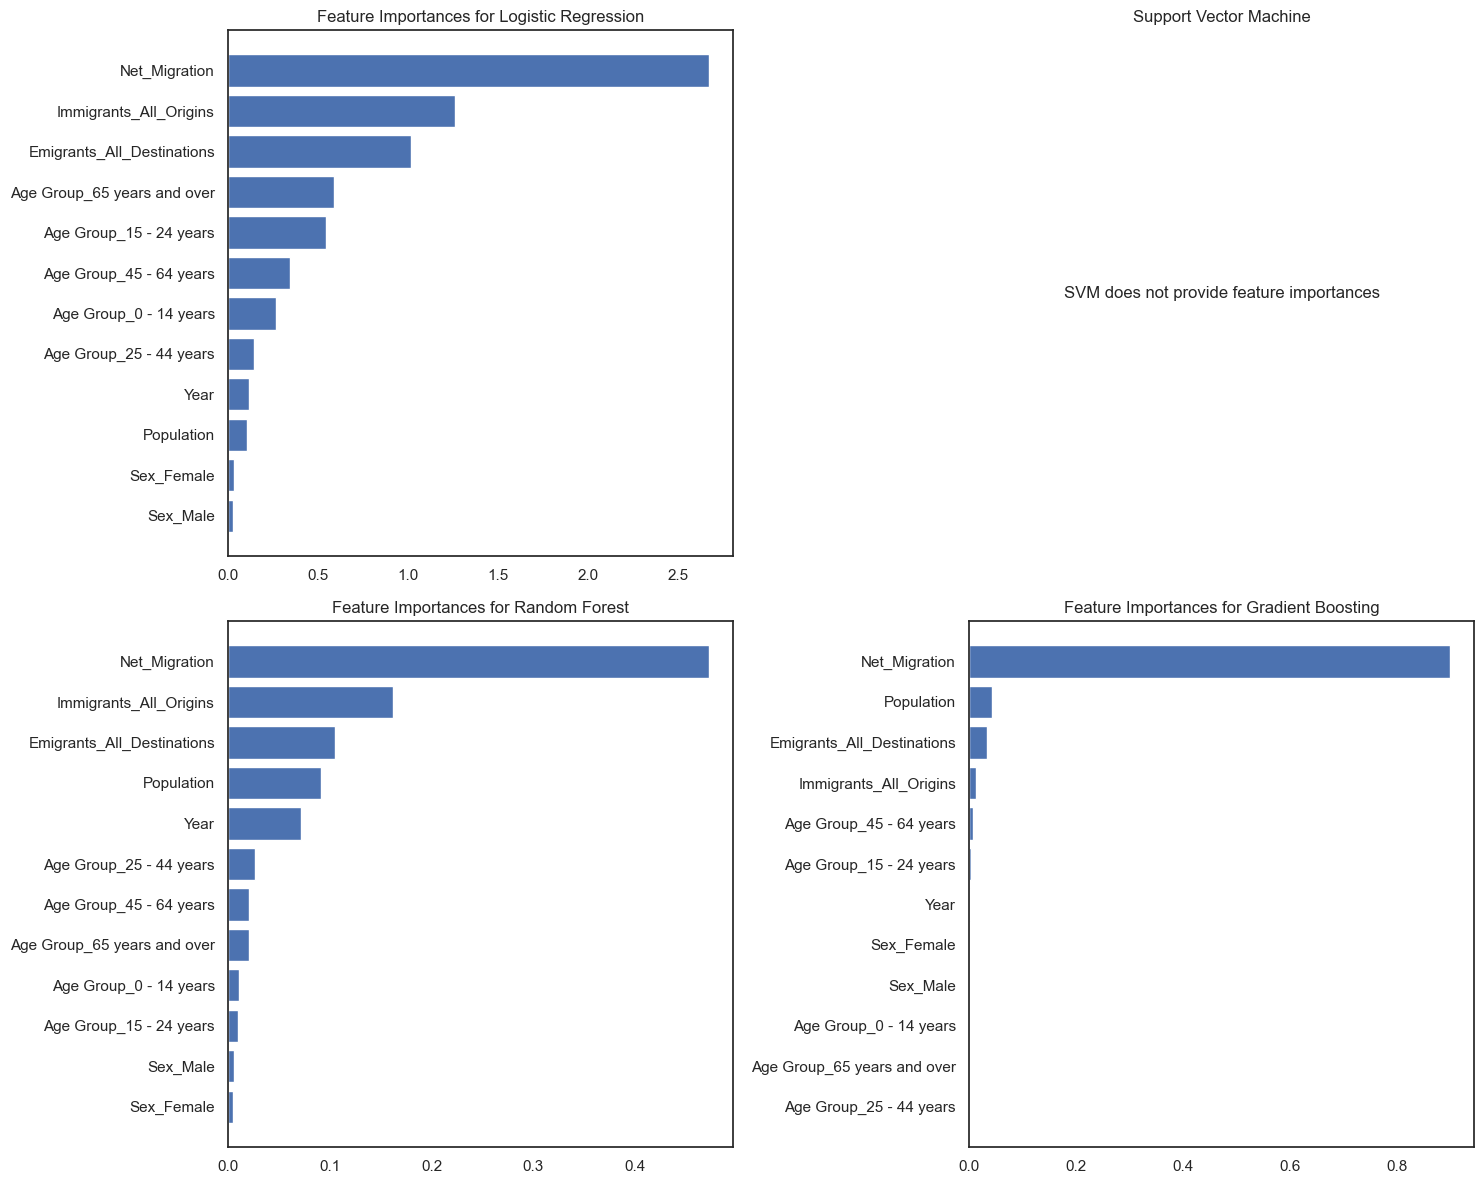

In [304]:
def plot_feature_importances(models, X_train, preprocessor):
    feature_names_transformed = preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)
    all_feature_names = np.concatenate([numerical_features, feature_names_transformed])

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    for idx, (name, model) in enumerate(models.items()):
        if name == "Support Vector Machine":
            axes[idx].text(0.5, 0.5, 'SVM does not provide feature importances',
                           verticalalignment='center', horizontalalignment='center',
                           transform=axes[idx].transAxes, fontsize=12)
            axes[idx].set_title(name)
            axes[idx].axis('off')
            continue
        
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('model', model)])
        pipeline.fit(X_train, y_train)

        if name in ["Random Forest", "Gradient Boosting"]:
            importances = pipeline.named_steps['model'].feature_importances_
        elif name == "Logistic Regression":
            importances = np.mean(np.abs(pipeline.named_steps['model'].coef_), axis=0)
        
        indices = np.argsort(importances)
        
        axes[idx].barh(range(len(indices)), importances[indices], align='center')
        axes[idx].set_yticks(range(len(indices)))
        axes[idx].set_yticklabels(all_feature_names[indices])
        axes[idx].set_title(f'Feature Importances for {name}')
    
    plt.tight_layout()
    plt.show()
    
plot_feature_importances(models, X_train, preprocessor)


* For the Logistic Regression model, the feature importances are represented by the average absolute values of the coefficients across all classes. 
* For the Random Forest and Gradient Boosting models, the importances are based on the impurity decrease brought by each feature.
* Support Vector Machine (SVM) model does not inherently provide a feature importance measure, which is why its graph is omitted.
  
These graphs provide insights into which features are most influential for each model when making predictions. Features at the top of each graph are the most important, and those at the bottom are the least important.